# Find precipitation value for pulsed and upslope storms divided into 5 wind regimes

In [1]:
import sys
#sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python')
sys.path.append('/home/franzihe/Documents/Python/Thesis')

import numpy as np
import netCDF4
import matplotlib.pyplot as plt

import createFolder as cF
np.warnings.filterwarnings('ignore')

import seaborn as sns
import fct_windspeed_sorting as fct

import matplotlib as mpl
import pandas as pd

from scipy.stats import pearsonr, spearmanr, kendalltau, kde, linregress

In [2]:
# plot cosmetics
sns.set_context('paper')

sns.set(font = 'Serif', font_scale = 1.2, )
sns.set_style('ticks', 
                  {'font.family':'serif', #'font.serif':'Helvetica'
                   'grid.linestyle': '--',
                   'axes.grid': True,
                  }, 
                   )
# Set the palette to the "pastel" default palette:
sns.set_palette("colorblind")

In [3]:
#pal = sns.color_palette("colorblind")
#pal.as_hex()

In [4]:
m = [ '12', '01', '02']
station = 'Haukeliseter'
meps_run = ['CTRL', 'ICE-T']
meps_run = np.arange(0,10).astype('<U21')
meps_run = np.hstack((np.arange(0,10), ['CTRL', 'ICE-T']))
meps_run

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'CTRL', 'ICE-T'],
      dtype='<U21')

In [5]:
savefig = 0
if savefig == 1:
    if len(meps_run) == 2:
        figdir = '/home/franzihe/Documents/Figures/Weathermast_MEPS_Retrieval/%s/CTRL_ICET/' %(station)
    if len(meps_run) == 10:
        figdir = '/home/franzihe/Documents/Figures/Weathermast_MEPS_Retrieval/%s/EM0_9/' %(station)
    if len(meps_run) == 12:
        figdir = '/home/franzihe/Documents/Figures/Weathermast_MEPS_Retrieval/%s/EM09_CTRL_ICET/' %(station)
    cF.createFolder('%s/' %figdir)
    form = 'png'

In [6]:
f = dict()
obs_precip_diff      = dict()
obs_precip_diff_2deg = dict()
obs_west_idx         = dict()
obs_east_idx         = dict()
obs_wind_dir         = dict()
obs_wind_speed       = dict()
obs_precip_total_2deg= dict()
obs_precip_west_2deg = dict()
obs_precip_east_2deg = dict()
    
meps_precip_diff     = dict()
meps_precip_diff_2deg= dict()
meps_west_idx        = dict()
meps_east_idx        = dict()
meps_wind_dir        = dict()
meps_wind_speed      = dict()
meps_precip_total_2deg= dict()
meps_precip_west_2deg = dict()
meps_precip_east_2deg = dict()
    
ret_precip_diff      = dict()
ret_precip_total     = dict()
ret_precip_west      = dict()
ret_precip_east      = dict()



for meps in meps_run:
    meps_wind_dir[meps]         = dict()
    meps_wind_speed[meps]       = dict()
    meps_precip_diff[meps]      = dict()
    meps_precip_diff_2deg[meps] = dict()
    meps_west_idx[meps]         = dict()
    meps_east_idx[meps]         = dict()
    meps_precip_total_2deg[meps]= dict()
    meps_precip_west_2deg[meps] = dict()
    meps_precip_east_2deg[meps] = dict()
    
    date = []
    for month in m:
        if month == '12' or  month == '01':
            t = np.arange(1,32)
        if month == '02':
            t = np.arange(1,29)
        if month == '11' or month == '12':
            year = '2016'
        if month == '01' or month == '02' or month == '03':
            year = '2017'

        for day in t:

            if day < 10:
                day = '0%s' %day
            else:
                day = '%s' %day


            Date = int(year+month+day)
            nc_dir = '/home/franzihe/Documents/Data/Weathermast_MEPS_Retrieval/%s/%s' %(station,meps)
            
            try:
                f[Date] = netCDF4.Dataset(nc_dir+'/weathermast_meps_retrieval_%s_12.nc' %(Date), 'r')
            except FileNotFoundError:
              #  print('no file found {:}: {:}'.format(meps, Date))
                continue

            
            if len(f[Date].variables) != 0:
#                print(Date, 'no valid data')
 #           else:
                if np.nansum(f[Date].variables['obs_precipitation_difference_2degC']) >= 0.25 \
                and np.nansum(f[Date].variables['ret_precipitation_difference']) >= 0.25:
             #   and np.nansum(f[Date].variables['meps_precipitation_difference_2degC']) >= 0.25 \
                
                    date = np.append(date, int(Date))
                   # print(Date)
                    obs_wind_dir[Date]         = f[Date].variables['obs_wind_direction'][:]
                    obs_wind_speed[Date]       = f[Date].variables['obs_wind_speed'][:]
                    obs_precip_diff[Date]      = f[Date].variables['obs_precipitation_difference'][:]
                    obs_precip_diff_2deg[Date] = f[Date].variables['obs_precipitation_difference_2degC'][:]
                    obs_west_idx[Date]         = f[Date].variables['obs_idx_westerly'][:].astype(int)
                    obs_east_idx[Date]         = f[Date].variables['obs_idx_easterly'][:].astype(int)

                    meps_wind_dir[meps][Date]        = f[Date].variables['meps_wind_direction'][:]
                    meps_wind_speed[meps][Date]      = f[Date].variables['meps_wind_speed'][:]
                    meps_precip_diff[meps][Date]     = f[Date].variables['meps_precipitation_difference'][:]
                    meps_precip_diff_2deg[meps][Date]= f[Date].variables['meps_precipitation_difference_2degC'][:]
                    meps_west_idx[meps][Date]        = f[Date].variables['meps_idx_westerly'][:]
                    meps_east_idx[meps][Date]        = f[Date].variables['meps_idx_easterly'][:]

                    ret_precip_diff[Date]      = f[Date].variables['ret_precipitation_difference'][:]

                    
                    ############################################
                    ## assign 24h sums
                    if len(obs_west_idx[Date]) == 0 and len(obs_east_idx[Date]) == 0:
                        obs_precip_total[Date] = np.nan
                        obs_precip_west[Date]  = np.nan
                        obs_precip_east[Date]  = np.nan
                        
                    ### observation == reference
                    obs_precip_total_2deg[Date] = np.nansum(obs_precip_diff_2deg[Date][obs_west_idx[Date],]) + \
                                                  np.nansum(obs_precip_diff_2deg[Date][obs_east_idx[Date],])
                    obs_precip_west_2deg[Date]  = np.nansum(obs_precip_diff_2deg[Date][obs_west_idx[Date],])
                    obs_precip_east_2deg[Date]  = np.nansum(obs_precip_diff_2deg[Date][obs_east_idx[Date],])

                    ### retrieval
                    ret_precip_total[Date] = np.nansum(ret_precip_diff[Date][obs_west_idx[Date],]) + \
                                             np.nansum(ret_precip_diff[Date][obs_east_idx[Date],])
                    ret_precip_west[Date]  = np.nansum(ret_precip_diff[Date][obs_west_idx[Date],])
                    ret_precip_east[Date]  = np.nansum(ret_precip_diff[Date][obs_east_idx[Date],])
                
                    ### MEPS
                    meps_precip_total_2deg[meps][Date] = np.nansum(meps_precip_diff_2deg[meps][Date][~np.isnan(meps_west_idx[meps][Date]),]) + \
                                                         np.nansum(meps_precip_diff_2deg[meps][Date][~np.isnan(meps_east_idx[meps][Date]),])
                    meps_precip_west_2deg[meps][Date] = np.nansum(meps_precip_diff_2deg[meps][Date][~np.isnan(meps_west_idx[meps][Date]),])
                    meps_precip_east_2deg[meps][Date] = np.nansum(meps_precip_diff_2deg[meps][Date][~np.isnan(meps_east_idx[meps][Date]),])
#            try:

#                print('{:} (west, east, total); '
 #                         'obs: {:.2f}, {:.2f}, {:.2f}; '
  #                        'ret: {:.2f}, {:.2f}, {:.2f}; \
   #                       MEPS - {:}: {:.2f}, {:.2f}, {:.2f}; '
    #                      'MEPS - {:}: {:.2f}, {:.2f}, {:.2f};'.format(Date,
     #                                                                 obs_precip_west_2deg[Date],
      #                                                                obs_precip_east_2deg[Date],
       #                                                               obs_precip_total_2deg[Date],
        #                                                              ret_precip_west[Date],
         #                                                             ret_precip_east[Date],
          #                                                            ret_precip_total[Date],
           #                                                           'CTRL',
            #                                                          meps_precip_west_2deg['CTRL'][Date],
             #                                                         meps_precip_east_2deg['CTRL'][Date],
              #                                                        meps_precip_total_2deg['CTRL'][Date],
               #                                                       'ICE-T',
                #                                                      meps_precip_west_2deg['ICE-T'][Date],
                 #                                                     meps_precip_east_2deg['ICE-T'][Date],
                  #                                                    meps_precip_total_2deg['ICE-T'][Date]))
#            except KeyError:
  #              continue
                        
                        
            f[Date].close()

            ############################################
       


# Get monthly sum of precipitation and calculate % difference

\begin{equation*}
\frac{RET - OBS}{OBS} * 100 = Diff [\%]
\end{equation*}

\begin{equation*}
\frac{MEPS - OBS}{OBS} * 100 = Diff [\%]
\end{equation*}


In [7]:
def calc_monthly_precip_sum(date, precip_total, precip_east, precip_west):
    
    # calculate monthly precip sum observation for <2degC, and valid days
    total = []
    total_east = []
    total_west  = []


    monthly_sum  = 0.0
    monthly_east_sum  = 0.0
    monthly_west_sum  = 0.0
    for Date in date:
        Date = int(Date)

        if Date == int(20161201) or Date == int(20170102) or Date == int(20170202):
            monthly_sum  = 0.0
            monthly_east_sum  = 0.0
            monthly_west_sum  = 0.0

        tot_val  = (precip_total[Date])
        monthly_sum  = np.nansum([ monthly_sum ,tot_val ])

        east_val  = (precip_east[Date])
        monthly_east_sum  = np.nansum([ monthly_east_sum , east_val ])

        west_val  = (precip_west[Date])
        monthly_west_sum  = np.nansum([ monthly_west_sum , west_val ])

        if Date == int(20161231) or Date == int(20170128) or Date == int(20170206):
                     total.append( monthly_sum )
                     total_east.append( monthly_east_sum )
                     total_west.append( monthly_west_sum )

    
    return(np.asarray(total),  np.asarray(total_east),  np.asarray(total_west))

In [8]:
def calc_percentage_diff(obs_total, ret_total):
    diff_perc_monthly = (ret_total - obs_total)/obs_total * 100
    diff_perc_season  = (np.nansum(ret_total) - np.nansum(obs_total))/np.nansum(obs_total) * 100
    
    return(diff_perc_monthly, diff_perc_season)

In [9]:
## DoFe observation
obs_total, obs_total_east, obs_total_west = calc_monthly_precip_sum(date, obs_precip_total_2deg, obs_precip_east_2deg, obs_precip_west_2deg)

## Retrieval
ret_total, ret_total_east, ret_total_west = calc_monthly_precip_sum(date, ret_precip_total, ret_precip_east, ret_precip_west)
# seasonal
ret_obs_monthly, ret_obs_season           = calc_percentage_diff(obs_total, ret_total)
ret_obs_monthly_east, ret_obs_season_east = calc_percentage_diff(obs_total_east, ret_total_east)
ret_obs_monthly_west, ret_obs_season_west = calc_percentage_diff(obs_total_west, ret_total_west)

## MEPS
meps_total = dict()
meps_total_east = dict()
meps_total_west = dict()
meps_obs_monthly = dict()
meps_obs_season  = dict()
meps_obs_monthly_east = dict()
meps_obs_season_east  = dict()
meps_obs_monthly_west = dict()
meps_obs_season_west  = dict()
for meps in meps_run:
    meps_total[meps], meps_total_east[meps], meps_total_west[meps] = calc_monthly_precip_sum(date, meps_precip_total_2deg[meps], meps_precip_east_2deg[meps], meps_precip_west_2deg[meps])
    
    meps_obs_monthly[meps], meps_obs_season[meps] = calc_percentage_diff(obs_total, meps_total[meps])
    meps_obs_monthly_east[meps], meps_obs_season_east[meps] = calc_percentage_diff(obs_total_east, meps_total_east[meps])
    meps_obs_monthly_west[meps], meps_obs_season_west[meps] = calc_percentage_diff(obs_total_west, meps_total_west[meps])

In [10]:
def plt_seasonal_stat(obs_total, obs_total_west, obs_total_east,
                      ret_total, ret_total_west, ret_total_east,
                      ret_obs_monthly, ret_obs_monthly_west, ret_obs_monthly_east,
                      ret_obs_season, ret_obs_season_west, ret_obs_season_east,
                       observation):
    ### create table for Retrieval Obs result
    col_labels = ['Obs [mm]', observation + '[mm]' ,'Difference [%]', ]
    row_labels = ['', 'Dec 2016', 'Jan 2017', 'Feb 2017',  'Winter 2016-2017',
                  '', 
                  '',  'Dec 2016', 'Jan 2017', 'Feb 2017',  'Winter 2016-2017',
                  '',
                  '',  'Dec 2016', 'Jan 2017', 'Feb 2017',  'Winter 2016-2017'
                 ]
    table_vals = [ ['', '' , '' ],
                   ['{:.2f}'.format(obs_total[0]), '{:.2f}'.format(ret_total[0]), '{:.2f}'.format(ret_obs_monthly[0])],
                   ['{:.2f}'.format(obs_total[1]), '{:.2f}'.format(ret_total[1]), '{:.2f}'.format(ret_obs_monthly[1])],
                   ['{:.2f}'.format(obs_total[2]), '{:.2f}'.format(ret_total[2]), '{:.2f}'.format(ret_obs_monthly[2])],
                   ['{:.2f}'.format(np.nansum(obs_total)), '{:.2f}'.format(np.nansum(ret_total)), '{:.2f}'.format(ret_obs_season)],
                 #
                   ['', '' , '' ],
                   ['', '' , '' ],
                   ['{:.2f}'.format(obs_total_west[0]), '{:.2f}'.format(ret_total_west[0]), '{:.2f}'.format(ret_obs_monthly_west[0])],
                   ['{:.2f}'.format(obs_total_west[1]), '{:.2f}'.format(ret_total_west[1]), '{:.2f}'.format(ret_obs_monthly_west[1])],
                   ['{:.2f}'.format(obs_total_west[2]), '{:.2f}'.format(ret_total_west[2]), '{:.2f}'.format(ret_obs_monthly_west[2])],
                   ['{:.2f}'.format(np.nansum(obs_total_west)), '{:.2f}'.format(np.nansum(ret_total_west)), '{:.2f}'.format(ret_obs_season_west)],
                 #
                   ['', '' , '' ],
                   ['', '' , '' ],
                   ['{:.2f}'.format(obs_total_east[0]), '{:.2f}'.format(ret_total_east[0]), '{:.2f}'.format(ret_obs_monthly_east[0])],
                   ['{:.2f}'.format(obs_total_east[1]), '{:.2f}'.format(ret_total_east[1]), '{:.2f}'.format(ret_obs_monthly_east[1])],
                   ['{:.2f}'.format(obs_total_east[2]), '{:.2f}'.format(ret_total_east[2]), '{:.2f}'.format(ret_obs_monthly_east[2])],
                   ['{:.2f}'.format(np.nansum(obs_total_east)), '{:.2f}'.format(np.nansum(ret_total_east)), '{:.2f}'.format(ret_obs_season_east)]
                 ]

    # Draw table
    fig, axsm = plt.subplots(1, 1, #sharex = 'all', 
                             # sharey = 'all',
                             #figsize = [19.5,6]
                            )
    the_table = axsm.table(cellText = table_vals,
                          rowLabels= row_labels,
                          colLabels= col_labels,
                          loc = 'center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(1.2,1.7)



    # Removing ticks and spines enables you to get the figure only with table
    axsm.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axsm.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
            plt.gca().spines[pos].set_visible(False)

    axsm.text(0.4, 1.41, observation,
                verticalalignment='center', horizontalalignment='center',
                transform=axsm.transAxes,
                color='black', #fontsize=15, 
                fontweight='bold', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5.5});
    axsm.text(-0.32, 1.2, 'Total Precipitation',
              verticalalignment='center', horizontalalignment='center',
                transform=axsm.transAxes,
                color='black', #fontsize=15, 
                #fontweight='bold', 
              bbox={'facecolor': 'k', 'alpha': 0.5, #'pad': 5.5
                                        });

    axsm.text(-0.4, 0.64, 'Westerly',
              verticalalignment='center', horizontalalignment='center',
                transform=axsm.transAxes,
                color='black', #fontsize=15, 
                #fontweight='bold', 
              bbox={'facecolor': 'b', 'alpha': 0.5, #'pad': 5.5
                                        });
    axsm.text(-0.4, 0.08, 'Easterly',
              verticalalignment='center', horizontalalignment='center',
                transform=axsm.transAxes,
                color='black', #fontsize=15, 
                #fontweight='bold', 
              bbox={'facecolor': 'r', 'alpha': 0.5, #'pad': 5.5
                                        });

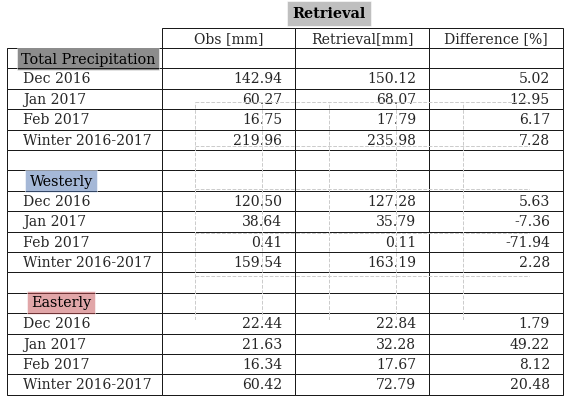

In [11]:
#observation = 'Retrieval'
plt_seasonal_stat(obs_total, obs_total_west, obs_total_east,
                      ret_total, ret_total_west, ret_total_east,
                      ret_obs_monthly, ret_obs_monthly_west, ret_obs_monthly_east,
                      ret_obs_season, ret_obs_season_west, ret_obs_season_east,
                       'Retrieval')
if savefig == 1:
        fig_name = 'winter_16_17_percent_diff_ret'+'.'+form
        plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir,fig_name))
        plt.close()

In [12]:
def calc_ensemble_mean(meps):
    meps_EM = np.nanmean(np.stack((meps[str(0)], meps[str(1)],
                                  meps[str(2)], meps[str(3)],
                                  meps[str(4)], meps[str(5)],
                                  meps[str(6)], meps[str(7)],
                                  meps[str(8)], meps[str(9)]), axis = 0), axis = 0)
    return(meps_EM)

In [13]:
if len(meps_run) == 10 or len(meps_run) == 12:
    np.nanmean(np.stack((meps_total_west[str(0)], meps_total_west[str(1)],
          meps_total_west[str(2)], meps_total_west[str(3)],
          meps_total_west[str(4)], meps_total_west[str(5)],
          meps_total_west[str(6)], meps_total_west[str(7)],
          meps_total_west[str(8)], meps_total_west[str(9)]), axis = 0), axis = 0)

#    pd.DataFrame(np.stack((meps_precip_west_ws[str(0)][:,1], meps_precip_west_ws[str(1)][:,1],
 #         meps_precip_west_ws[str(2)][:,1], meps_precip_west_ws[str(3)][:,1],
  #        meps_precip_west_ws[str(4)][:,1], meps_precip_west_ws[str(5)][:,1],
   #       meps_precip_west_ws[str(6)][:,1], meps_precip_west_ws[str(7)][:,1], 
    #      meps_precip_west_ws[str(8)][:,1], meps_precip_west_ws[str(9)][:,1]), axis = 0))

#    pd.DataFrame(np.nansum(np.nanmean(np.stack((meps_precip_west_ws[str(0)][:,1], meps_precip_west_ws[str(1)][:,1],
 #         meps_precip_west_ws[str(2)][:,1], meps_precip_west_ws[str(3)][:,1],
  #        meps_precip_west_ws[str(4)][:,1], meps_precip_west_ws[str(5)][:,1],
   #       meps_precip_west_ws[str(6)][:,1], meps_precip_west_ws[str(7)][:,1], 
    #      meps_precip_west_ws[str(8)][:,1], meps_precip_west_ws[str(9)][:,1]), axis = 0), axis = 0)))

#    pd.DataFrame(np.stack((meps_precip_east_ws[str(0)][:,1], meps_precip_east_ws[str(1)][:,1],
 #         meps_precip_east_ws[str(2)][:,1], meps_precip_east_ws[str(3)][:,1],
  #        meps_precip_east_ws[str(4)][:,1], meps_precip_east_ws[str(5)][:,1],
   #       meps_precip_east_ws[str(6)][:,1], meps_precip_east_ws[str(7)][:,1], 
    #      meps_precip_east_ws[str(8)][:,1], meps_precip_east_ws[str(9)][:,1]), axis = 0))

#    pd.DataFramenp.nansum((np.nanmean(np.stack((meps_precip_east_ws[str(0)][:,1], meps_precip_east_ws[str(1)][:,1],
 #         meps_precip_east_ws[str(2)][:,1], meps_precip_east_ws[str(3)][:,1],
  #        meps_precip_east_ws[str(4)][:,1], meps_precip_east_ws[str(5)][:,1],
   #       meps_precip_east_ws[str(6)][:,1], meps_precip_east_ws[str(7)][:,1], 
    #      meps_precip_east_ws[str(8)][:,1], meps_precip_east_ws[str(9)][:,1]), axis = 0), axis = 0)))

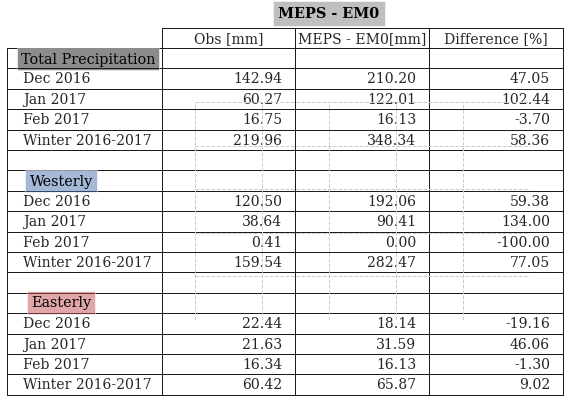

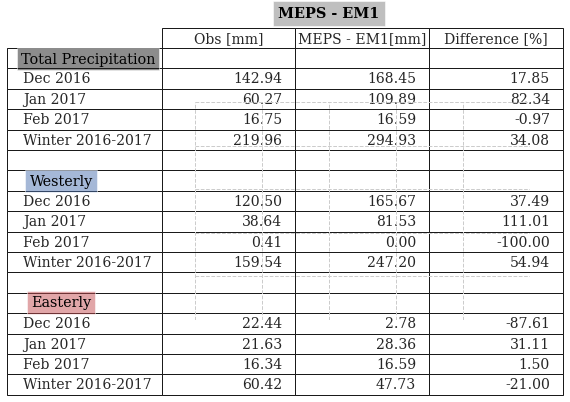

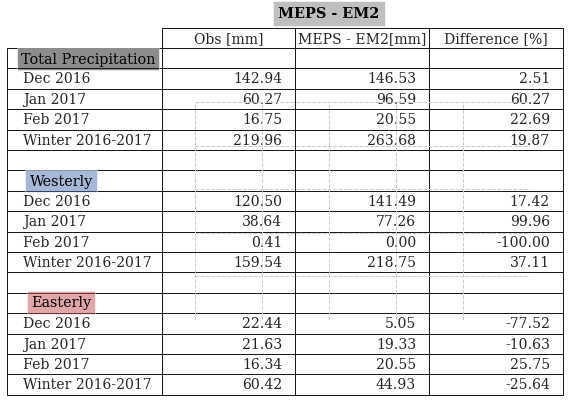

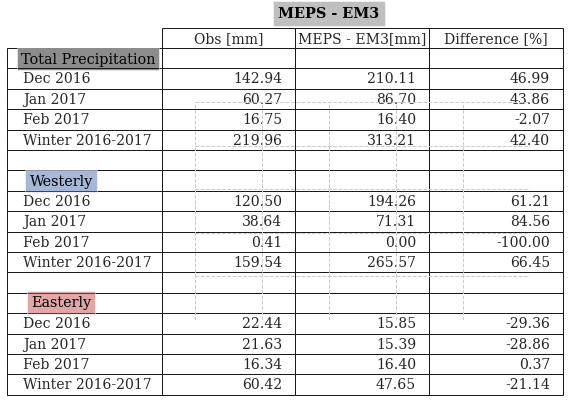

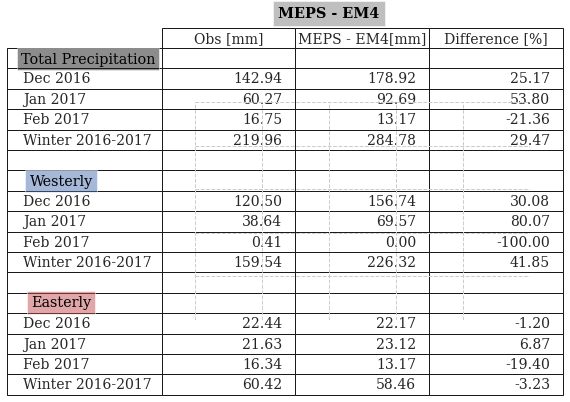

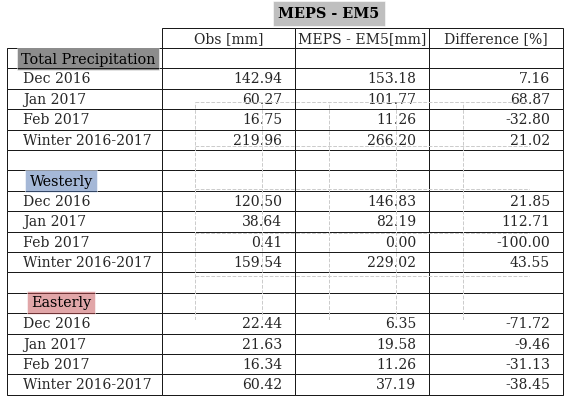

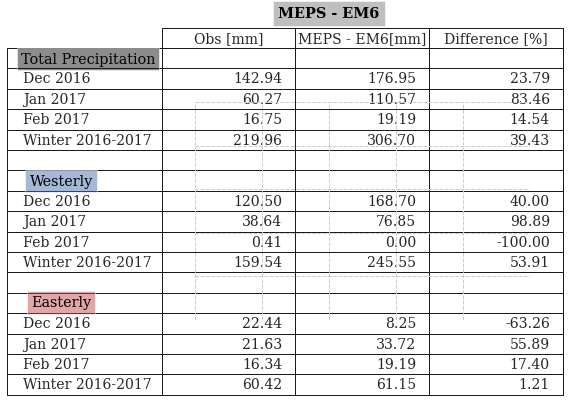

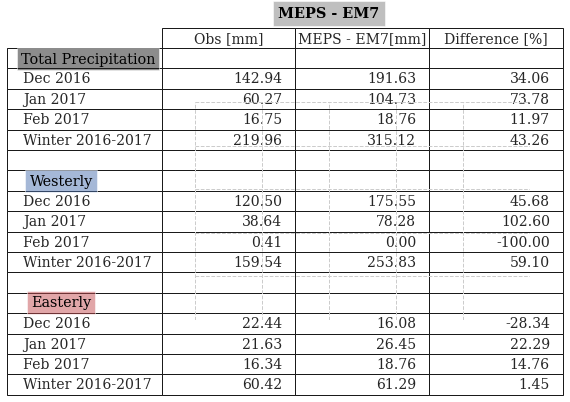

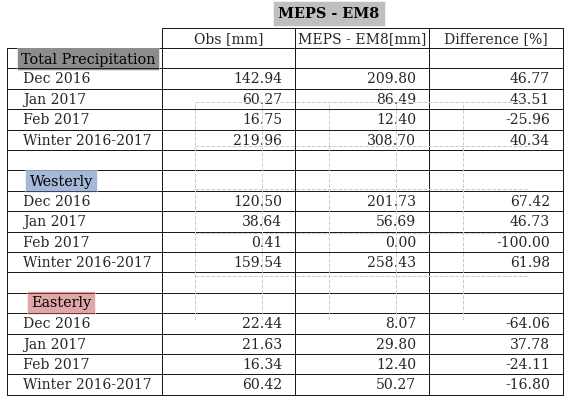

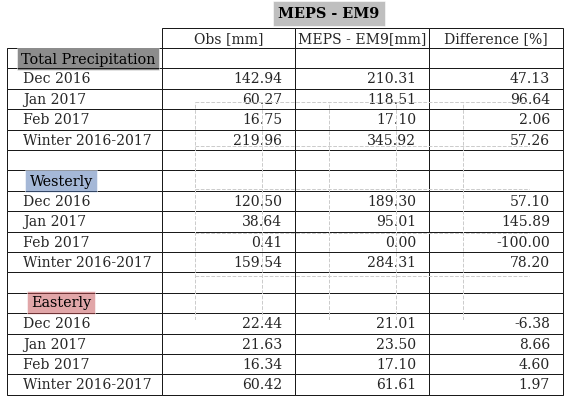

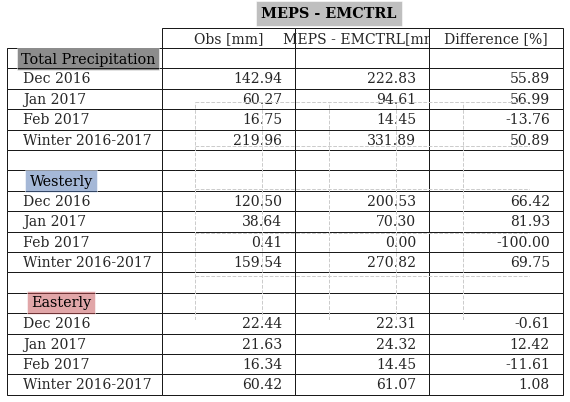

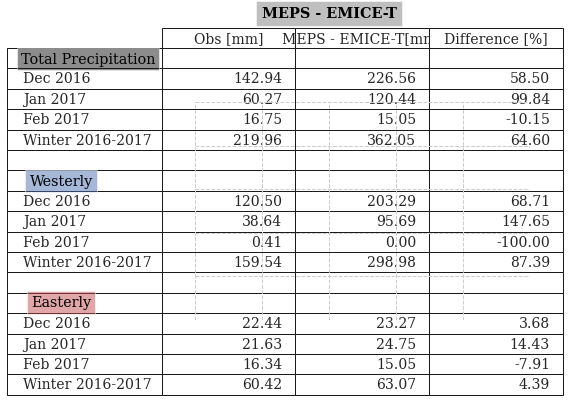

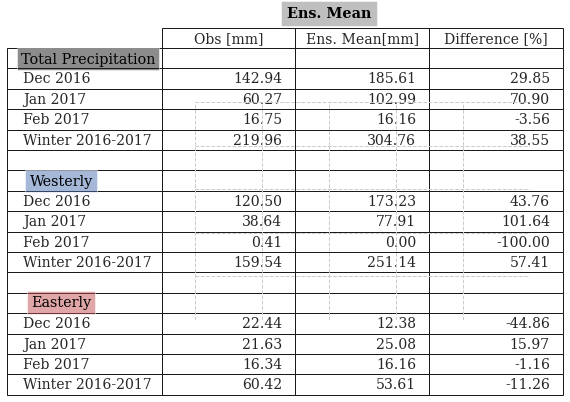

In [14]:
if len(meps_run) == 10 or len(meps_run) == 12:

    meps_total_EM      = calc_ensemble_mean(meps_total)
    meps_total_west_EM = calc_ensemble_mean(meps_total_west)
    meps_total_east_EM = calc_ensemble_mean(meps_total_east)

    meps_obs_monthly_EM      = calc_ensemble_mean(meps_obs_monthly)
    meps_obs_monthly_west_EM = calc_ensemble_mean(meps_obs_monthly_west)
    meps_obs_monthly_east_EM = calc_ensemble_mean(meps_obs_monthly_east)

    meps_obs_season_EM      = calc_ensemble_mean(meps_obs_season)
    meps_obs_season_west_EM = calc_ensemble_mean(meps_obs_season_west)
    meps_obs_season_east_EM = calc_ensemble_mean(meps_obs_season_east)


    for meps in meps_run:
        plt_seasonal_stat(obs_total, obs_total_west, obs_total_east,
                      meps_total[meps], meps_total_west[meps], meps_total_east[meps],
                      meps_obs_monthly[meps], meps_obs_monthly_west[meps], meps_obs_monthly_east[meps],
                      meps_obs_season[meps], meps_obs_season_west[meps], meps_obs_season_east[meps],
                       'MEPS - EM{:}'.format(str(meps)))
        
        if savefig == 1:
            fig_name = 'winter_16_17_percent_diff_MEPS_%s' %(meps) +'.'+form
            plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
            print('plot saved: %s/%s' %(figdir,fig_name))
            plt.close()
            
    plt_seasonal_stat(obs_total, obs_total_west, obs_total_east,
                      meps_total_EM, meps_total_west_EM, meps_total_east_EM,
                      meps_obs_monthly_EM, meps_obs_monthly_west_EM, meps_obs_monthly_east_EM,
                      meps_obs_season_EM, meps_obs_season_west_EM, meps_obs_season_east_EM,
                      'Ens. Mean')
    
    if savefig == 1:
            fig_name = 'winter_16_17_percent_diff_MEPS_EM' +'.'+form
            plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
            print('plot saved: %s/%s' %(figdir,fig_name))
            plt.close()

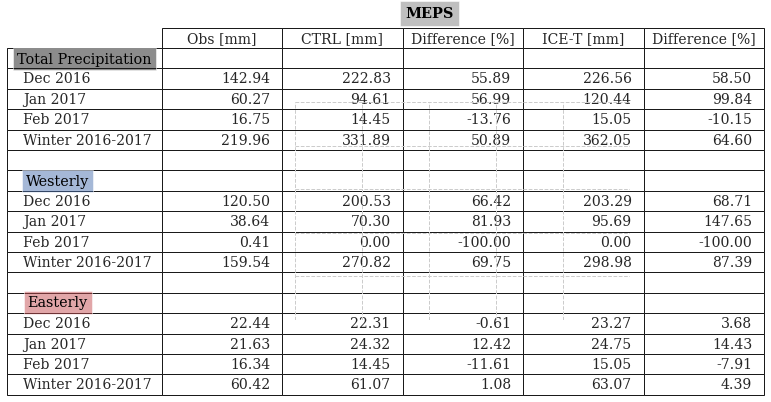

In [15]:
if len(meps_run) == 2 or len(meps_run) ==12:
    

    ### create table for Retrieval Obs result
    col_labels = ['Obs [mm]', 'CTRL [mm]','Difference [%]', 'ICE-T [mm]','Difference [%]',]
    row_labels = ['', 'Dec 2016', 'Jan 2017', 'Feb 2017',  'Winter 2016-2017',
                  '', 
                  '',  'Dec 2016', 'Jan 2017', 'Feb 2017',  'Winter 2016-2017',
                  '',
                  '',  'Dec 2016', 'Jan 2017', 'Feb 2017',  'Winter 2016-2017'
                 ]
    table_vals = [ ['', '' , '' , '' , '' ],
                   ['{:.2f}'.format(obs_total[0]), '{:.2f}'.format(meps_total['CTRL'][0]), '{:.2f}'.format(meps_obs_monthly['CTRL'][0]), '{:.2f}'.format(meps_total['ICE-T'][0]), '{:.2f}'.format(meps_obs_monthly['ICE-T'][0])],
                   ['{:.2f}'.format(obs_total[1]), '{:.2f}'.format(meps_total['CTRL'][1]), '{:.2f}'.format(meps_obs_monthly['CTRL'][1]), '{:.2f}'.format(meps_total['ICE-T'][1]), '{:.2f}'.format(meps_obs_monthly['ICE-T'][1])],
                   ['{:.2f}'.format(obs_total[2]), '{:.2f}'.format(meps_total['CTRL'][2]), '{:.2f}'.format(meps_obs_monthly['CTRL'][2]), '{:.2f}'.format(meps_total['ICE-T'][2]), '{:.2f}'.format(meps_obs_monthly['ICE-T'][2])],
                   ['{:.2f}'.format(np.nansum(obs_total)), '{:.2f}'.format(np.nansum(meps_total['CTRL'])), '{:.2f}'.format(meps_obs_season['CTRL']), '{:.2f}'.format(np.nansum(meps_total['ICE-T'])), '{:.2f}'.format(meps_obs_season['ICE-T'])],
                  # 
                   ['', '' , '' , '' , '' ],
                   ['', '' , '' , '' , '' ],
                   ['{:.2f}'.format(obs_total_west[0]), '{:.2f}'.format(meps_total_west['CTRL'][0]), '{:.2f}'.format(meps_obs_monthly_west['CTRL'][0]), 
                                                        '{:.2f}'.format(meps_total_west['ICE-T'][0]), '{:.2f}'.format(meps_obs_monthly_west['ICE-T'][0])],
                   ['{:.2f}'.format(obs_total_west[1]), '{:.2f}'.format(meps_total_west['CTRL'][1]), '{:.2f}'.format(meps_obs_monthly_west['CTRL'][1]), 
                                                        '{:.2f}'.format(meps_total_west['ICE-T'][1]), '{:.2f}'.format(meps_obs_monthly_west['ICE-T'][1])],
                   ['{:.2f}'.format(obs_total_west[2]), '{:.2f}'.format(meps_total_west['CTRL'][2]), '{:.2f}'.format(meps_obs_monthly_west['CTRL'][2]), 
                                                        '{:.2f}'.format(meps_total_west['ICE-T'][2]), '{:.2f}'.format(meps_obs_monthly_west['ICE-T'][2])],
                   ['{:.2f}'.format(np.nansum(obs_total_west)), '{:.2f}'.format(np.nansum(meps_total_west['CTRL'])), '{:.2f}'.format(meps_obs_season_west['CTRL']), 
                                                             '{:.2f}'.format(np.nansum(meps_total_west['ICE-T'])), '{:.2f}'.format(meps_obs_season_west['ICE-T'])],
                   ['', '' , '' , '' , '' ],
                   ['', '' , '' , '' , '' ],
                   ['{:.2f}'.format(obs_total_east[0]), '{:.2f}'.format(meps_total_east['CTRL'][0]), '{:.2f}'.format(meps_obs_monthly_east['CTRL'][0]), 
                                                        '{:.2f}'.format(meps_total_east['ICE-T'][0]), '{:.2f}'.format(meps_obs_monthly_east['ICE-T'][0])],
                   ['{:.2f}'.format(obs_total_east[1]), '{:.2f}'.format(meps_total_east['CTRL'][1]), '{:.2f}'.format(meps_obs_monthly_east['CTRL'][1]), 
                                                        '{:.2f}'.format(meps_total_east['ICE-T'][1]), '{:.2f}'.format(meps_obs_monthly_east['ICE-T'][1])],
                   ['{:.2f}'.format(obs_total_east[2]), '{:.2f}'.format(meps_total_east['CTRL'][2]), '{:.2f}'.format(meps_obs_monthly_east['CTRL'][2]), 
                                                        '{:.2f}'.format(meps_total_east['ICE-T'][2]), '{:.2f}'.format(meps_obs_monthly_east['ICE-T'][2])],
                   ['{:.2f}'.format(np.nansum(obs_total_east)), '{:.2f}'.format(np.nansum(meps_total_east['CTRL'])), '{:.2f}'.format(meps_obs_season_east['CTRL']), 
                                                             '{:.2f}'.format(np.nansum(meps_total_east['ICE-T'])), '{:.2f}'.format(meps_obs_season_east['ICE-T'])],

                 ]


    # Draw table
    fig, axsm = plt.subplots(1, 1, #sharex = 'all', 
                             # sharey = 'all',
                             #figsize = [19.5,6]
                            )
    the_table = axsm.table(cellText = table_vals,
                          rowLabels= row_labels,
                          colLabels= col_labels,
                          loc = 'center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(1.8,1.7)




    # Removing ticks and spines enables you to get the figure only with table
    axsm.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axsm.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
            plt.gca().spines[pos].set_visible(False)

    axsm.text(0.4, 1.41, 'MEPS',
                verticalalignment='center', horizontalalignment='center',
                transform=axsm.transAxes,
                color='black', #fontsize=15, 
                fontweight='bold', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5.5});
    axsm.text(-0.63, 1.2, 'Total Precipitation',
              verticalalignment='center', horizontalalignment='center',
                transform=axsm.transAxes,
                color='black', #fontsize=15, 
                #fontweight='bold', 
              bbox={'facecolor': 'k', 'alpha': 0.5, #'pad': 5.5
                                        });

    axsm.text(-0.71, 0.64, 'Westerly',
              verticalalignment='center', horizontalalignment='center',
                transform=axsm.transAxes,
                color='black', #fontsize=15, 
                #fontweight='bold', 
              bbox={'facecolor': 'b', 'alpha': 0.5, #'pad': 5.5
                                        });
    axsm.text(-0.71, 0.08, 'Easterly',
              verticalalignment='center', horizontalalignment='center',
                transform=axsm.transAxes,
                color='black', #fontsize=15, 
                #fontweight='bold', 
              bbox={'facecolor': 'r', 'alpha': 0.5, #'pad': 5.5
                                        });
    plt.tight_layout()

    if savefig == 1:
            fig_name = 'winter_16_17_percent_diff_MEPS'+'.'+form
            plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
            print('plot saved: %s/%s' %(figdir,fig_name))
            plt.close()

# Seperate precipiation into wind direction and wind speed classes

- easterlies: 22.5 - 202.5
- westerlies: 202.5 - 22.5$^{o}C$

WS: [0 - 4), [4 - 8), [8 - 12), [12 - 16), [16 - 20), [20 - inf) m s$^{-1}$

In [16]:
### DFAR observation
obs_precip_west_0_4, obs_precip_east_0_4, \
obs_precip_west_4_8, obs_precip_east_4_8, \
obs_precip_west_8_12, obs_precip_east_8_12, \
obs_precip_west_12_16,obs_precip_east_12_16, \
obs_precip_west_16_20,obs_precip_east_16_20, \
obs_precip_west_20,obs_precip_east_20 =  fct.get_precip_amount_for_wind_speed(obs_precip_diff_2deg, obs_wind_dir, obs_west_idx, obs_east_idx, obs_wind_speed)

In [17]:
obs_precip_west_ws = [np.nansum(obs_precip_west_0_4[:,:],axis= 0),
                      np.nansum(obs_precip_west_4_8[:,:],axis= 0),
                      np.nansum(obs_precip_west_8_12[:,:],axis= 0),
                      np.nansum(obs_precip_west_12_16[:,:],axis= 0),
                      np.nansum(obs_precip_west_16_20[:,:],axis= 0),
                      np.nansum(obs_precip_west_20[:,:],axis= 0)]
obs_precip_west_ws = np.array(obs_precip_west_ws)
#obs_precip_west_ws[np.where(obs_precip_west_ws[:,:] == 0.0)] = np.nan

obs_precip_east_ws = [np.nansum(obs_precip_east_0_4[:,:],axis= 0),
                      np.nansum(obs_precip_east_4_8[:,:],axis= 0),
                      np.nansum(obs_precip_east_8_12[:,:],axis= 0),
                      np.nansum(obs_precip_east_12_16[:,:],axis= 0),
                      np.nansum(obs_precip_east_16_20[:,:],axis= 0),
                      np.nansum(obs_precip_east_20[:,:],axis= 0)]
obs_precip_east_ws = np.array(obs_precip_east_ws)
#obs_precip_east_ws[np.where(obs_precip_east_ws[:,:] == 0.0)] = np.nan

In [18]:
### retrieved values
ret_precip_west_0_4, ret_precip_east_0_4, \
ret_precip_west_4_8, ret_precip_east_4_8, \
ret_precip_west_8_12, ret_precip_east_8_12, \
ret_precip_west_12_16,ret_precip_east_12_16, \
ret_precip_west_16_20,ret_precip_east_16_20, \
ret_precip_west_20,ret_precip_east_20 =  fct.get_precip_amount_for_wind_speed(ret_precip_diff, obs_wind_dir, obs_west_idx, obs_east_idx, obs_wind_speed)


In [19]:
ret_precip_west_ws = [np.nansum(ret_precip_west_0_4[:,:],axis= 0),
                      np.nansum(ret_precip_west_4_8[:,:],axis= 0),
                      np.nansum(ret_precip_west_8_12[:,:],axis= 0),
                      np.nansum(ret_precip_west_12_16[:,:],axis= 0),
                      np.nansum(ret_precip_west_16_20[:,:],axis= 0),
                      np.nansum(ret_precip_west_20[:,:],axis= 0)]
ret_precip_west_ws = np.array(ret_precip_west_ws)
#ret_precip_west_ws[np.where(ret_precip_west_ws[:,:] == 0.0)] = np.nan

ret_precip_east_ws = [np.nansum(ret_precip_east_0_4[:,:],axis= 0),
                      np.nansum(ret_precip_east_4_8[:,:],axis= 0),
                      np.nansum(ret_precip_east_8_12[:,:],axis= 0),
                      np.nansum(ret_precip_east_12_16[:,:],axis= 0),
                      np.nansum(ret_precip_east_16_20[:,:],axis= 0),
                      np.nansum(ret_precip_east_20[:,:],axis= 0)]
ret_precip_east_ws = np.array(ret_precip_east_ws)
#ret_precip_east_ws[np.where(ret_precip_east_ws[:,:] == 0.0)] = np.nan

## MEPS

In [20]:
meps_precip_west_ws = dict()
meps_precip_east_ws = dict()

meps_west_count = dict()
meps_east_count = dict()

for meps in meps_run:
    ### meps forecast
    meps_precip_west_0_4, meps_precip_east_0_4, \
    meps_precip_west_4_8, meps_precip_east_4_8, \
    meps_precip_west_8_12, meps_precip_east_8_12, \
    meps_precip_west_12_16,meps_precip_east_12_16, \
    meps_precip_west_16_20,meps_precip_east_16_20, \
    meps_precip_west_20,meps_precip_east_20 =  fct.get_precip_amount_for_wind_speed_MEPS(meps_precip_diff_2deg[meps], 
                                                                                               meps_wind_dir[meps], 
                                                                                               meps_west_idx[meps], 
                                                                                               meps_east_idx[meps], 
                                                                                               meps_wind_speed[meps])

    meps_precip_west_ws[meps] = [np.nansum(meps_precip_west_0_4[:,:],axis= 0),
                          np.nansum(meps_precip_west_4_8[:,:],axis= 0),
                          np.nansum(meps_precip_west_8_12[:,:],axis= 0),
                          np.nansum(meps_precip_west_12_16[:,:],axis= 0),
                          np.nansum(meps_precip_west_16_20[:,:],axis= 0),
                          np.nansum(meps_precip_west_20[:,:],axis= 0)]
    meps_precip_west_ws[meps] = np.array(meps_precip_west_ws[meps])
#    meps_precip_west_ws[meps][np.where(meps_precip_west_ws[meps][:,:] == 0.0)] = np.nan

    #meps_precip_west_ws_mean = np.nanmean(meps_precip_west_ws[:,1:], axis = 1)

    meps_precip_east_ws[meps] = [np.nansum(meps_precip_east_0_4[:,:],axis= 0),
                          np.nansum(meps_precip_east_4_8[:,:],axis= 0),
                          np.nansum(meps_precip_east_8_12[:,:],axis= 0),
                          np.nansum(meps_precip_east_12_16[:,:],axis= 0),
                          np.nansum(meps_precip_east_16_20[:,:],axis= 0),
                          np.nansum(meps_precip_east_20[:,:],axis= 0)]
    meps_precip_east_ws[meps] = np.array(meps_precip_east_ws[meps])
#    meps_precip_east_ws[meps][np.where(meps_precip_east_ws[meps][:,:] == 0.0)] = np.nan

    #meps_precip_east_ws_mean = np.nanmean(meps_precip_east_ws[:,1:], axis = 1)
    
    ### count the hours precipitation was observed
    meps_west_ones_0_4 = np.ones(shape = meps_precip_west_0_4[:,1].shape[0])
    meps_west_count_0_4 = np.sum(meps_west_ones_0_4[np.logical_and(meps_precip_west_0_4[:,1] != 0,
                                                                 ~np.isnan(meps_precip_west_0_4[:,1]))])
    meps_west_ones_4_8 = np.ones(shape = meps_precip_west_4_8[:,1].shape[0])
    meps_west_count_4_8 = np.sum(meps_west_ones_4_8[np.logical_and(meps_precip_west_4_8[:,1] != 0,
                                                                 ~np.isnan(meps_precip_west_4_8[:,1]))])
    meps_west_ones_8_12 = np.ones(shape = meps_precip_west_8_12[:,1].shape[0])
    meps_west_count_8_12 = np.sum(meps_west_ones_8_12[np.logical_and(meps_precip_west_8_12[:,1] != 0,
                                                                   ~np.isnan(meps_precip_west_8_12[:,1]))])
    meps_west_ones_12_16 = np.ones(shape = meps_precip_west_12_16[:,1].shape[0])
    meps_west_count_12_16 = np.sum(meps_west_ones_12_16[np.logical_and(meps_precip_west_12_16[:,1] != 0,
                                                                     ~np.isnan(meps_precip_west_12_16[:,1]))])
    meps_west_ones_16_20 = np.ones(shape = meps_precip_west_16_20[:,1].shape[0])
    meps_west_count_16_20 = np.sum(meps_west_ones_16_20[np.logical_and(meps_precip_west_16_20[:,1] != 0,
                                                                     ~np.isnan(meps_precip_west_16_20[:,1]))])
    meps_west_ones_20 = np.ones(shape = meps_precip_west_20[:,1].shape[0])
    meps_west_count_20 = np.sum(meps_west_ones_20[np.logical_and(meps_precip_west_20[:,1] != 0,
                                                                     ~np.isnan(meps_precip_west_20[:,1]))])
    
    meps_east_ones_0_4 = np.ones(shape = meps_precip_east_0_4[:,1].shape[0])
    meps_east_count_0_4 = np.sum(meps_east_ones_0_4[np.logical_and(meps_precip_east_0_4[:,1] != 0,
                                                                 ~np.isnan(meps_precip_east_0_4[:,1]))])
    meps_east_ones_4_8 = np.ones(shape = meps_precip_east_4_8[:,1].shape[0])
    meps_east_count_4_8 = np.sum(meps_east_ones_4_8[np.logical_and(meps_precip_east_4_8[:,1] != 0,
                                                                 ~np.isnan(meps_precip_east_4_8[:,1]))])
    meps_east_ones_8_12 = np.ones(shape = meps_precip_east_8_12[:,1].shape[0])
    meps_east_count_8_12 = np.sum(meps_east_ones_8_12[np.logical_and(meps_precip_east_8_12[:,1] != 0,
                                                                   ~np.isnan(meps_precip_east_8_12[:,1]))])
    meps_east_ones_12_16 = np.ones(shape = meps_precip_east_12_16[:,1].shape[0])
    meps_east_count_12_16 = np.sum(meps_east_ones_12_16[np.logical_and(meps_precip_east_12_16[:,1] != 0,
                                                                     ~np.isnan(meps_precip_east_12_16[:,1]))])
    meps_east_ones_16_20 = np.ones(shape = meps_precip_east_16_20[:,1].shape[0])
    meps_east_count_16_20 = np.sum(meps_east_ones_16_20[np.logical_and(meps_precip_east_16_20[:,1] != 0,
                                                                     ~np.isnan(meps_precip_east_16_20[:,1]))])
    meps_east_ones_20 = np.ones(shape = meps_precip_east_20[:,1].shape[0])
    meps_east_count_20 = np.sum(meps_east_ones_20[np.logical_and(meps_precip_east_20[:,1] != 0,
                                                                     ~np.isnan(meps_precip_east_20[:,1]))])
    
    meps_west_count[meps] = [meps_west_count_0_4,
                  meps_west_count_4_8,
                  meps_west_count_8_12,
                  meps_west_count_12_16,
                  meps_west_count_16_20,
                  meps_west_count_20]
    meps_west_count[meps] = np.array(meps_west_count[meps])
    
    meps_east_count[meps] = [meps_east_count_0_4,
                  meps_east_count_4_8,
                  meps_east_count_8_12,
                  meps_east_count_12_16,
                  meps_east_count_16_20,
                  meps_east_count_20]
    meps_east_count[meps] = np.array(meps_east_count[meps])

In [21]:
def plt_precip_in_wind_category(axs, west=None, east=None, observation=None):
    
    bar_width = 0.35
    opacity = 0.4
    bar11 = axs.bar(np.arange(west.shape[0]) - bar_width/2,
                    west[:], width = bar_width,
                    align = 'center', alpha = opacity, color = 'b',
                    label = 'westerlies {:.1f}'.format(np.nansum(west[:])))
    bar12 = axs.bar(np.arange(east.shape[0]) + bar_width/2,
                    east[:], width = bar_width,
                    align = 'center', alpha = opacity, color = 'r',
                    label = 'easterlies {:.1f}'.format(np.nansum(east[:])))
    axs.text(0.4, 0.95, observation,
            verticalalignment='center', horizontalalignment='center',
            transform=axs.transAxes,
            color='black', fontsize=15, fontweight='bold', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5.5})
    # Add counts above the two bar graphs
    for rect in bar11 + bar12:
        height = rect.get_height()
        if np.isnan(height):
            continue
        else:
            axs.text(rect.get_x() + rect.get_width()/2.0, height, '{:.1f}'.format(height), ha='center', va='bottom')
    axs.legend(bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand',fancybox=True, facecolor ='white')

    
    axs.set_xticklabels(['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'], rotation=30)



In [22]:
if len(meps_run) == 2:
    fig, axsm = plt.subplots(1, 4, sharex = 'all', 
                              sharey = 'all',
                             figsize = [19.5,6])

    axs = axsm.flatten()

    for i in range(axs.shape[0]):
        axs[i].set_xlabel('Wind speed (m/s)')
    axs[0].set_ylabel('precipitation (mm)')
    axs[0].set_xticks(np.arange(obs_precip_west_ws.shape[0]))

    plt_precip_in_wind_category(axs[0], obs_precip_west_ws[:,1],
                                obs_precip_east_ws[:,1], 'DFAR')

    plt_precip_in_wind_category(axs[1], ret_precip_west_ws[:,1],
                                ret_precip_east_ws[:,1], 'Retrieval')

    for i, meps in zip(np.arange(2,np.array(meps_run).shape[0]+2), meps_run):
        plt_precip_in_wind_category(axs[i], meps_precip_west_ws[meps][:,1],
                                    meps_precip_east_ws[meps][:,1], 'MEPS - %s' %meps)

    plt.tight_layout()
    if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_sfc_precip_WS_WD.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

In [23]:
if len(meps_run) == 10 or len(meps_run) == 12: 
    meps_precip_west_ws_EM = np.nanmean(np.stack((meps_precip_west_ws[str(0)][:,1], meps_precip_west_ws[str(1)][:,1],
                                              meps_precip_west_ws[str(2)][:,1], meps_precip_west_ws[str(3)][:,1],
                                              meps_precip_west_ws[str(4)][:,1], meps_precip_west_ws[str(5)][:,1],
                                              meps_precip_west_ws[str(6)][:,1], meps_precip_west_ws[str(7)][:,1],
                                              meps_precip_west_ws[str(8)][:,1], meps_precip_west_ws[str(9)][:,1],), axis = 0), axis = 0)

    meps_precip_east_ws_EM = np.nanmean(np.stack((meps_precip_east_ws[str(0)][:,1], meps_precip_east_ws[str(1)][:,1],
                                              meps_precip_east_ws[str(2)][:,1], meps_precip_east_ws[str(3)][:,1],
                                              meps_precip_east_ws[str(4)][:,1], meps_precip_east_ws[str(5)][:,1],
                                              meps_precip_east_ws[str(6)][:,1], meps_precip_east_ws[str(7)][:,1],
                                              meps_precip_east_ws[str(8)][:,1], meps_precip_east_ws[str(9)][:,1],), axis = 0), axis = 0)

    meps_west_count_EM = np.nanmean(np.stack((meps_west_count[str(0)], meps_west_count[str(1)],
                                              meps_west_count[str(2)], meps_west_count[str(3)],
                                              meps_west_count[str(4)], meps_west_count[str(5)],
                                              meps_west_count[str(6)], meps_west_count[str(7)],
                                              meps_west_count[str(8)], meps_west_count[str(9)],), axis = 0), axis = 0)

    meps_east_count_EM = np.nanmean(np.stack((meps_east_count[str(0)], meps_east_count[str(1)],
                                              meps_east_count[str(2)], meps_east_count[str(3)],
                                              meps_east_count[str(4)], meps_east_count[str(5)],
                                              meps_east_count[str(6)], meps_east_count[str(7)],
                                              meps_east_count[str(8)], meps_east_count[str(9)],), axis = 0), axis = 0)

In [24]:
if len(meps_run) == 10:
    


    fig, axsm = plt.subplots(1, 3, sharex = 'all', 
                              sharey = 'all',
                             figsize = [19.5,6])

    axs = axsm.flatten()

    for i in range(axs.shape[0]):
        axs[i].set_xlabel('Wind speed (m/s)')
    axs[0].set_ylabel('precipitation (mm)')
    axs[0].set_xticks(np.arange(obs_precip_west_ws.shape[0]))

    plt_precip_in_wind_category(axs[0], obs_precip_west_ws[:,1],
                                obs_precip_east_ws[:,1], 'DFAR')

    plt_precip_in_wind_category(axs[1], ret_precip_west_ws[:,1],
                                ret_precip_east_ws[:,1], 'Retrieval')

    plt_precip_in_wind_category(axs[2], meps_precip_west_ws_EM,
                                    meps_precip_east_ws_EM, 'MEPS - Ens. Mean' )

    plt.tight_layout()
    if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_sfc_precip_WS_WD_EM.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

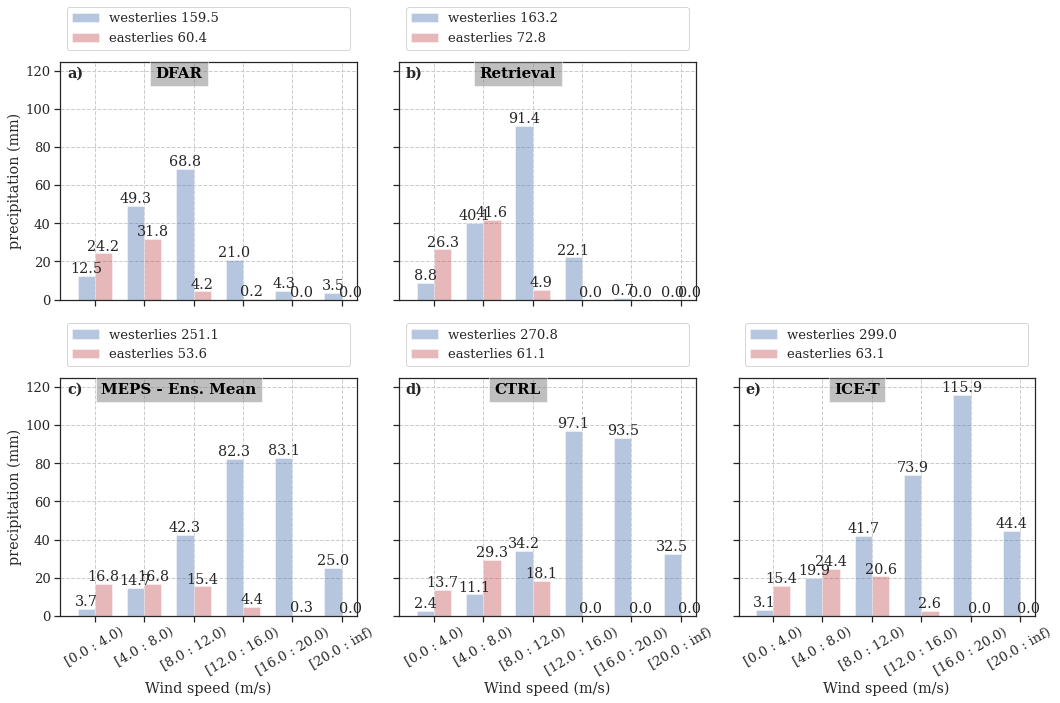

In [25]:
# subplots with DFAR, Retrieval, MEPS-EM, CTRL, ICE-T
fig_label = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']

fig, axsm = plt.subplots(2, 3, sharex = 'all', 
                              sharey = 'all',
                             figsize = [15,10])

axs = axsm.flatten()

for i in range(axs.shape[0]):
    axs[i].set_xlabel('Wind speed (m/s)')
axs[0].set_ylabel('precipitation (mm)')
axs[0].set_ylim([0, 125])
axs[0].set_xticks(np.arange(obs_precip_west_ws.shape[0]))
axs[0].set_xlim([0-0.7,6-0.7])



plt_precip_in_wind_category(axs[0], obs_precip_west_ws[:,1],
                                obs_precip_east_ws[:,1], 'DFAR')

plt_precip_in_wind_category(axs[1], ret_precip_west_ws[:,1],
                                ret_precip_east_ws[:,1], 'Retrieval')
for i in range(2):
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    axs[i].xaxis.label.set_visible(False)
    
axs[2].axis('off')

plt_precip_in_wind_category(axs[3], meps_precip_west_ws_EM,
                                    meps_precip_east_ws_EM, 'MEPS - Ens. Mean' )
axs[3].set_ylabel('precipitation (mm)')

for i, meps in zip(np.arange(4,6), meps_run[-2:]):
        plt_precip_in_wind_category(axs[i], meps_precip_west_ws[meps][:,1],
                                    meps_precip_east_ws[meps][:,1], '%s' %meps)
axs[5].set_ylim([0, 125])

for i in range(3,6):
    axs[i].text(0.05, 0.95,
                    fig_label[i-1],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
        
plt.tight_layout()
if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_sfc_precip_WS_WD_EM.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

In [26]:
def plt_precip_in_wind_category_V2(axs, west, observation, wd):
    
    bar_width = 0.35
    opacity = 0.4
    if wd == 'west':
        bar11 = axs.bar(np.arange(west.shape[0]) - bar_width/2,
                    west[:], width = bar_width,
                    align = 'center', alpha = opacity, color = 'b',
                    label = 'westerlies {:.1f}'.format(np.nansum(west[:])))
    if wd == 'east':
        bar11 = axs.bar(np.arange(west.shape[0]) + bar_width/2,
                    west[:], width = bar_width,
                    align = 'center', alpha = opacity, color = 'r',
                    label = 'easterlies {:.1f}'.format(np.nansum(west[:])))
        
    axs.text(0.4, 0.95, observation,
            verticalalignment='center', horizontalalignment='center',
            transform=axs.transAxes,
            color='black', fontsize=15, fontweight='bold', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5.5})
    # Add counts above the two bar graphs
    for rect in bar11:# + bar12:
        height = rect.get_height()
        if np.isnan(height):
            continue
        else:
            axs.text(rect.get_x() + rect.get_width()/2.0, height, '{:.1f}'.format(height), ha='center', va='bottom')
    axs.legend(bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand',fancybox=True, facecolor ='white')

    
    axs.set_xticklabels(['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'], rotation=30)



In [27]:
obs_west_ones_0_4 = np.ones(shape = obs_precip_west_0_4[:,1].shape[0])
obs_west_count_0_4 = np.sum(obs_west_ones_0_4[np.logical_and(obs_precip_west_0_4[:,1] != 0,
                                                             ~np.isnan(obs_precip_west_0_4[:,1]))])

obs_west_ones_4_8 = np.ones(shape = obs_precip_west_4_8[:,1].shape[0])
obs_west_count_4_8 = np.sum(obs_west_ones_4_8[np.logical_and(obs_precip_west_4_8[:,1] != 0,
                                                             ~np.isnan(obs_precip_west_4_8[:,1]))])

obs_west_ones_8_12 = np.ones(shape = obs_precip_west_8_12[:,1].shape[0])
obs_west_count_8_12 = np.sum(obs_west_ones_8_12[np.logical_and(obs_precip_west_8_12[:,1] != 0,
                                                               ~np.isnan(obs_precip_west_8_12[:,1]))])

obs_west_ones_12_16 = np.ones(shape = obs_precip_west_12_16[:,1].shape[0])
obs_west_count_12_16 = np.sum(obs_west_ones_12_16[np.logical_and(obs_precip_west_12_16[:,1] != 0,
                                                                 ~np.isnan(obs_precip_west_12_16[:,1]))])

obs_west_ones_16_20 = np.ones(shape = obs_precip_west_16_20[:,1].shape[0])
obs_west_count_16_20 = np.sum(obs_west_ones_16_20[np.logical_and(obs_precip_west_16_20[:,1] != 0,
                                                                 ~np.isnan(obs_precip_west_16_20[:,1]))])

obs_west_ones_20 = np.ones(shape = obs_precip_west_20[:,1].shape[0])
obs_west_count_20 = np.sum(obs_west_ones_20[np.logical_and(obs_precip_west_20[:,1] != 0,
                                                                 ~np.isnan(obs_precip_west_20[:,1]))])

obs_east_ones_0_4 = np.ones(shape = obs_precip_east_0_4[:,1].shape[0])
obs_east_count_0_4 = np.sum(obs_east_ones_0_4[np.logical_and(obs_precip_east_0_4[:,1] != 0,
                                                             ~np.isnan(obs_precip_east_0_4[:,1]))])

obs_east_ones_4_8 = np.ones(shape = obs_precip_east_4_8[:,1].shape[0])
obs_east_count_4_8 = np.sum(obs_east_ones_4_8[np.logical_and(obs_precip_east_4_8[:,1] != 0,
                                                             ~np.isnan(obs_precip_east_4_8[:,1]))])

obs_east_ones_8_12 = np.ones(shape = obs_precip_east_8_12[:,1].shape[0])
obs_east_count_8_12 = np.sum(obs_east_ones_8_12[np.logical_and(obs_precip_east_8_12[:,1] != 0,
                                                               ~np.isnan(obs_precip_east_8_12[:,1]))])

obs_east_ones_12_16 = np.ones(shape = obs_precip_east_12_16[:,1].shape[0])
obs_east_count_12_16 = np.sum(obs_east_ones_12_16[np.logical_and(obs_precip_east_12_16[:,1] != 0,
                                                                 ~np.isnan(obs_precip_east_12_16[:,1]))])

obs_east_ones_16_20 = np.ones(shape = obs_precip_east_16_20[:,1].shape[0])
obs_east_count_16_20 = np.sum(obs_east_ones_16_20[np.logical_and(obs_precip_east_16_20[:,1] != 0,
                                                                 ~np.isnan(obs_precip_east_16_20[:,1]))])

obs_east_ones_20 = np.ones(shape = obs_precip_east_20[:,1].shape[0])
obs_east_count_20 = np.sum(obs_east_ones_20[np.logical_and(obs_precip_east_20[:,1] != 0,
                                                                 ~np.isnan(obs_precip_east_20[:,1]))])

obs_west_count = [obs_west_count_0_4,
                  obs_west_count_4_8,
                  obs_west_count_8_12,
                  obs_west_count_12_16,
                  obs_west_count_16_20,
                  obs_west_count_20]

obs_east_count = [obs_east_count_0_4,
                  obs_east_count_4_8,
                  obs_east_count_8_12,
                  obs_east_count_12_16,
                  obs_east_count_16_20,
                  obs_east_count_20]

In [28]:
ret_west_ones_0_4 = np.ones(shape = ret_precip_west_0_4[:,1].shape[0])
ret_west_count_0_4 = np.sum(ret_west_ones_0_4[np.logical_and(ret_precip_west_0_4[:,1] != 0,
                                                             ~np.isnan(ret_precip_west_0_4[:,1]))])
ret_west_ones_4_8 = np.ones(shape = ret_precip_west_4_8[:,1].shape[0])
ret_west_count_4_8 = np.sum(ret_west_ones_4_8[np.logical_and(ret_precip_west_4_8[:,1] != 0,
                                                             ~np.isnan(ret_precip_west_4_8[:,1]))])
ret_west_ones_8_12 = np.ones(shape = ret_precip_west_8_12[:,1].shape[0])
ret_west_count_8_12 = np.sum(ret_west_ones_8_12[np.logical_and(ret_precip_west_8_12[:,1] != 0,
                                                               ~np.isnan(ret_precip_west_8_12[:,1]))])
ret_west_ones_12_16 = np.ones(shape = ret_precip_west_12_16[:,1].shape[0])
ret_west_count_12_16 = np.sum(ret_west_ones_12_16[np.logical_and(ret_precip_west_12_16[:,1] != 0,
                                                                 ~np.isnan(ret_precip_west_12_16[:,1]))])
ret_west_ones_16_20 = np.ones(shape = ret_precip_west_16_20[:,1].shape[0])
ret_west_count_16_20 = np.sum(ret_west_ones_16_20[np.logical_and(ret_precip_west_16_20[:,1] != 0,
                                                                 ~np.isnan(ret_precip_west_16_20[:,1]))])
ret_west_ones_20 = np.ones(shape = ret_precip_west_20[:,1].shape[0])
ret_west_count_20 = np.sum(ret_west_ones_20[np.logical_and(ret_precip_west_20[:,1] != 0,
                                                                 ~np.isnan(ret_precip_west_20[:,1]))])

ret_east_ones_0_4 = np.ones(shape = ret_precip_east_0_4[:,1].shape[0])
ret_east_count_0_4 = np.sum(ret_east_ones_0_4[np.logical_and(ret_precip_east_0_4[:,1] != 0,
                                                             ~np.isnan(ret_precip_east_0_4[:,1]))])
ret_east_ones_4_8 = np.ones(shape = ret_precip_east_4_8[:,1].shape[0])
ret_east_count_4_8 = np.sum(ret_east_ones_4_8[np.logical_and(ret_precip_east_4_8[:,1] != 0,
                                                             ~np.isnan(ret_precip_east_4_8[:,1]))])
ret_east_ones_8_12 = np.ones(shape = ret_precip_east_8_12[:,1].shape[0])
ret_east_count_8_12 = np.sum(ret_east_ones_8_12[np.logical_and(ret_precip_east_8_12[:,1] != 0,
                                                               ~np.isnan(ret_precip_east_8_12[:,1]))])
ret_east_ones_12_16 = np.ones(shape = ret_precip_east_12_16[:,1].shape[0])
ret_east_count_12_16 = np.sum(ret_east_ones_12_16[np.logical_and(ret_precip_east_12_16[:,1] != 0,
                                                                 ~np.isnan(ret_precip_east_12_16[:,1]))])
ret_east_ones_16_20 = np.ones(shape = ret_precip_east_16_20[:,1].shape[0])
ret_east_count_16_20 = np.sum(ret_east_ones_16_20[np.logical_and(ret_precip_east_16_20[:,1] != 0,
                                                                 ~np.isnan(ret_precip_east_16_20[:,1]))])
ret_east_ones_20 = np.ones(shape = ret_precip_east_20[:,1].shape[0])
ret_east_count_20 = np.sum(ret_east_ones_20[np.logical_and(ret_precip_east_20[:,1] != 0,
                                                                 ~np.isnan(ret_precip_east_20[:,1]))])

In [29]:
ret_west_count = [ret_west_count_0_4,
                  ret_west_count_4_8,
                  ret_west_count_8_12,
                  ret_west_count_12_16,
                  ret_west_count_16_20,
                  ret_west_count_20]

ret_east_count = [ret_east_count_0_4,
                  ret_east_count_4_8,
                  ret_east_count_8_12,
                  ret_east_count_12_16,
                  ret_east_count_16_20,
                  ret_east_count_20]

In [30]:
def plt_bar_obs_ret_meps(axs, west, x, observation):
    bar_width = 0.16
    opacity = 0.8
    
    bar = axs.bar(np.arange(len(west)) + x*bar_width,
                  west[:], width = bar_width,
                  align = 'center', alpha = opacity, #color = plt.get_cmap('Spectral_r'), #color = sns.color_palette("colorblind",5)[0]

                  label = '{:}: {:.0f}'.format(observation,np.nansum(west[:])))
    
    axs.set_xticks(np.arange(len(west)))
    axs.set_xticklabels(['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'],                         rotation=20)
    axs.set_xlabel('Wind speed (m/s)')

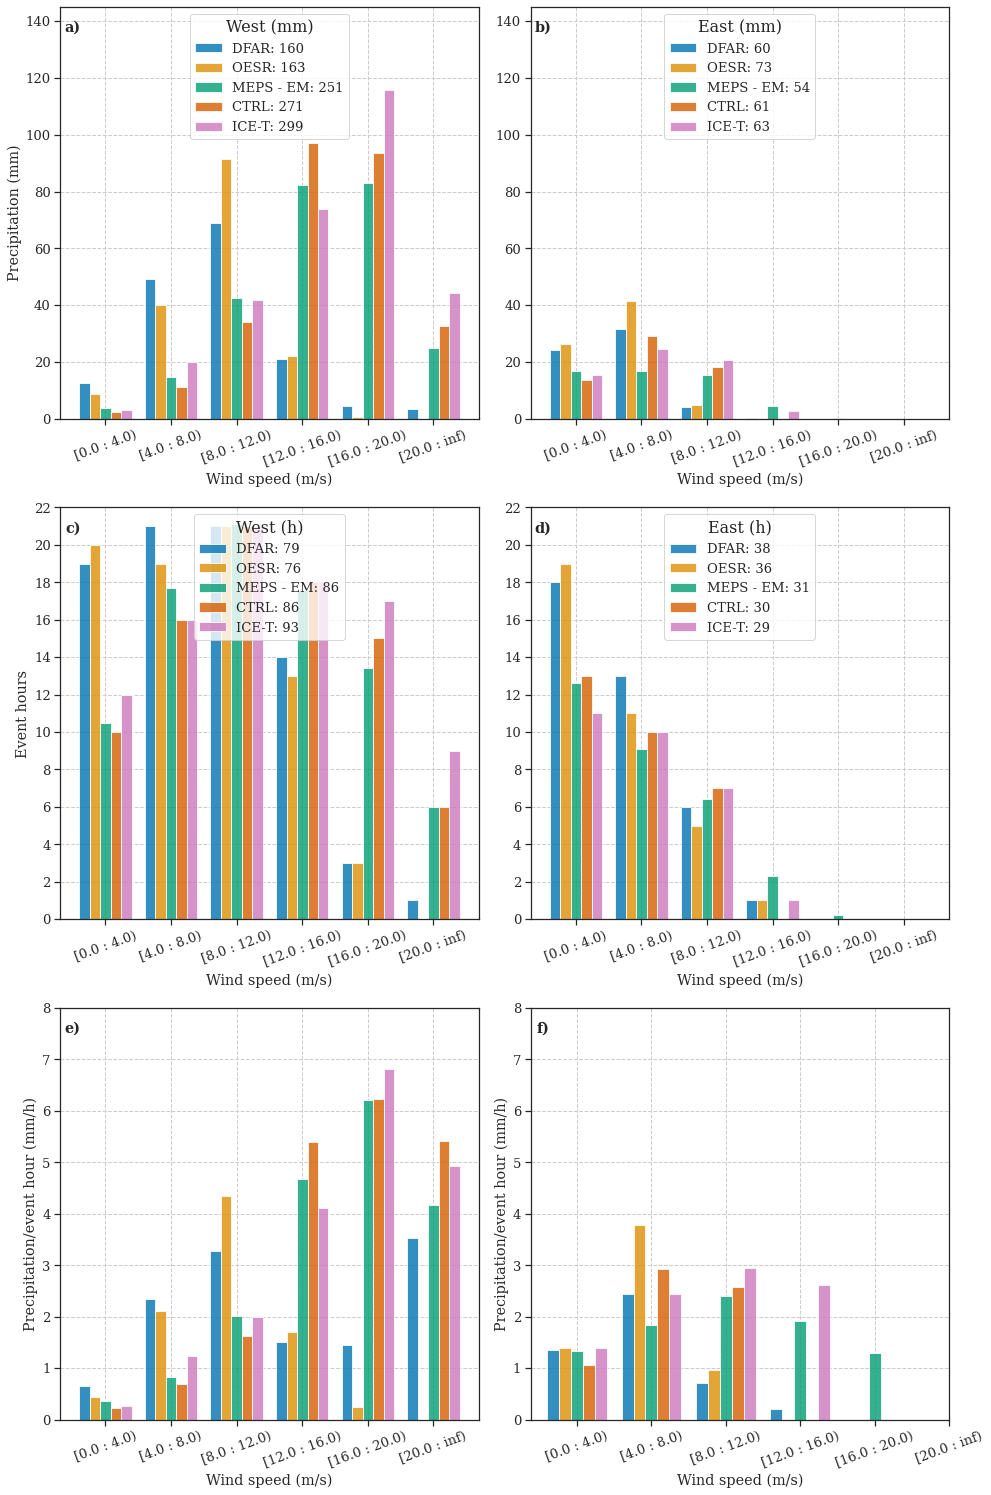

In [31]:
fig, axsm = plt.subplots(3, 2, #sharex = 'all', 
                             # sharey = 'all',
                             figsize = [14,21])

axs = axsm.flatten()

# westerlies
plt_bar_obs_ret_meps(axs[0], obs_precip_west_ws[:,1], -2, 'DFAR')
plt_bar_obs_ret_meps(axs[0], ret_precip_west_ws[:,1], -1, 'OESR')
plt_bar_obs_ret_meps(axs[0], meps_precip_west_ws_EM, 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[0], meps_precip_west_ws['CTRL'][:,1], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[0], meps_precip_west_ws['ICE-T'][:,1], +2, 'ICE-T')

axs[0].legend(loc = 'upper center', #bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', #mode='expand',
              fancybox=True, facecolor ='white', title = 'West (mm)', title_fontsize=16)
axs[0].set_ylabel('Precipitation (mm)')
axs[0].set_ylim([0, 145])

plt_bar_obs_ret_meps(axs[2], obs_west_count, -2, 'DFAR')
plt_bar_obs_ret_meps(axs[2], ret_west_count, -1, 'OESR')
plt_bar_obs_ret_meps(axs[2], meps_west_count_EM, 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[2], meps_west_count['CTRL'], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[2], meps_west_count['ICE-T'], +2, 'ICE-T')
axs[2].legend(loc = 'upper center',#bbox_to_anchor=(0,.92,1,0.2), loc='lower left', #mode='expand',
              fancybox=True, facecolor ='white', title = 'West (h)', title_fontsize=16)
axs[2].set_ylabel('Event hours')
axs[2].set_ylim([0, 22])
axs[2].set_yticks(np.arange(0,23,2))


plt_bar_obs_ret_meps(axs[4], obs_precip_west_ws[:,1]/obs_west_count, -2, 'DFAR')
plt_bar_obs_ret_meps(axs[4], ret_precip_west_ws[:,1]/ret_west_count, -1, 'OESR')
plt_bar_obs_ret_meps(axs[4], meps_precip_west_ws_EM/meps_west_count_EM, 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[4], meps_precip_west_ws['CTRL'][:,1]/ meps_west_count['CTRL'], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[4], meps_precip_west_ws['ICE-T'][:,1]/ meps_west_count['ICE-T'], +2, 'ICE-T')
axs[4].set_ylabel('Precipitation/event hour (mm/h)')
axs[4].set_ylim([0, 8])
axs[4].set_yticks(np.arange(0,9,1))



# easterlies
plt_bar_obs_ret_meps(axs[1], obs_precip_east_ws[:,1], -2, 'DFAR')
plt_bar_obs_ret_meps(axs[1], ret_precip_east_ws[:,1], -1, 'OESR')
plt_bar_obs_ret_meps(axs[1], meps_precip_east_ws_EM, 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[1], meps_precip_east_ws['CTRL'][:,1], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[1], meps_precip_east_ws['ICE-T'][:,1], +2, 'ICE-T')

axs[1].legend(loc = 'upper center',#bbox_to_anchor=(0,.92,1,0.2), loc='lower left', #mode='expand',
              fancybox=True, facecolor ='white', title = 'East (mm)', title_fontsize=16)
axs[1].set_ylim([0, 145])


plt_bar_obs_ret_meps(axs[3], obs_east_count, -2, 'DFAR')
plt_bar_obs_ret_meps(axs[3], ret_east_count, -1, 'OESR')
plt_bar_obs_ret_meps(axs[3], meps_east_count_EM, 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[3], meps_east_count['CTRL'], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[3], meps_east_count['ICE-T'], +2, 'ICE-T')
axs[3].legend(loc = 'upper center',#bbox_to_anchor=(0,.92,1,0.2), loc='lower left', #mode='expand',
              fancybox=True, facecolor ='white', title = 'East (h)', title_fontsize=16)
axs[3].set_ylim([0, 22])
axs[3].set_yticks(np.arange(0,23,2))

plt_bar_obs_ret_meps(axs[5], obs_precip_east_ws[:,1]/obs_east_count, -2, 'DFAR')
plt_bar_obs_ret_meps(axs[5], ret_precip_east_ws[:,1]/ret_east_count, -1, 'OESR')
plt_bar_obs_ret_meps(axs[5], meps_precip_east_ws_EM/meps_east_count_EM, 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[5], meps_precip_east_ws['CTRL'][:,1]/ meps_east_count['CTRL'], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[5], meps_precip_east_ws['ICE-T'][:,1]/ meps_east_count['ICE-T'], +2, 'ICE-T')
axs[5].set_ylabel('Precipitation/event hour (mm/h)')
axs[5].set_ylim([0, 8])
axs[5].set_yticks(np.arange(0,9,1))



for i in range(6):
    axs[i].text(0.03, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)

plt.tight_layout()
if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_sfc_precip_WS_WD_count.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

In [32]:
obs_wd = np.empty(shape = (24,))
obs_wd[:] = np.nan

obs_ws = obs_wd


meps_wd = dict() #
meps_ws = dict()
meps_wd['MEPS'] = obs_wd
meps_wd['CTRL'] = obs_wd
meps_wd['ICE-T'] = obs_wd

meps_ws['MEPS'] = obs_wd
meps_ws['CTRL'] = obs_wd
meps_ws['ICE-T'] = obs_wd

for meps in meps_run:
    meps_wd[meps] = obs_wd
    meps_ws[meps] = obs_wd
    
for Date in date:
    if len(obs_wind_dir[Date]) > 24:
        obs_wd = np.vstack((obs_wd, obs_wind_dir[Date][::60]), )
        obs_ws = np.vstack((obs_ws, obs_wind_speed[Date][::60],))
    else:
        obs_wd = np.vstack((obs_wd, obs_wind_dir[Date]))
        obs_ws = np.vstack((obs_ws, obs_wind_speed[Date]))  
    _em = (np.nanmean(np.stack((meps_wind_dir['0'][Date][1:,], meps_wind_dir['1'][Date][1:,], 
                                  meps_wind_dir['2'][Date][1:,], meps_wind_dir['3'][Date][1:,],
                                  meps_wind_dir['4'][Date][1:,], meps_wind_dir['5'][Date][1:,],
                                  meps_wind_dir['6'][Date][1:,], meps_wind_dir['7'][Date][1:,],
                                  meps_wind_dir['8'][Date][1:,], meps_wind_dir['9'][Date][1:,]), ), axis =0))    
    meps_wd['MEPS']= np.vstack((meps_wd['MEPS'], _em, ))
    for meps in meps_run:
        meps_wd[meps] = np.vstack((meps_wd[meps], meps_wind_dir[meps][Date][1:,]))
        meps_ws[meps] = np.vstack((meps_ws[meps], meps_wind_speed[meps][Date][1:,]))
#    meps_wd['CTRL'] = np.vstack((meps_wd['CTRL'], meps_wind_dir['CTRL'][Date][1:,]))
 #   meps_wd['ICE-T'] = np.vstack((meps_wd['ICE-T'], meps_wind_dir['ICE-T'][Date][1:,]))
    
    _em = (np.nanmean(np.stack((meps_wind_speed['0'][Date][1:,], meps_wind_speed['1'][Date][1:,], 
                                  meps_wind_speed['2'][Date][1:,], meps_wind_speed['3'][Date][1:,],
                                  meps_wind_speed['4'][Date][1:,], meps_wind_speed['5'][Date][1:,],
                                  meps_wind_speed['6'][Date][1:,], meps_wind_speed['7'][Date][1:,],
                                  meps_wind_speed['8'][Date][1:,], meps_wind_speed['9'][Date][1:,]), ), axis =0))
    meps_ws['MEPS'] = np.vstack((meps_ws['MEPS'], _em,))
    
 #   meps_ws['CTRL'] = np.vstack((meps_ws['CTRL'], meps_wind_speed['CTRL'][Date][1:,]))
  #  meps_ws['ICE-T'] = np.vstack((meps_ws['ICE-T'], meps_wind_speed['ICE-T'][Date][1:,]))

In [33]:
def annoate_correlation(axs, x, y, var):
    
    if var == 'wd':
        _x = np.linspace(0,360,60)
    elif var == 'ws':
        _x = np.linspace(0,25,12)
    _y = _x*linregress(x, y).slope + linregress(x, y).intercept

    axs.plot(_x, _y, 'r', linewidth = '2', )#color=sns.color_palette("colorblind",5)[-1])

    annotation_string_w = r"""    
        y = {:.2f}*x + {:.2f}
        R$^2$: {:.2f}
        """.format(linregress(x, y).slope, linregress(x, y).intercept, linregress(x, y).rvalue**2, linregress(x,y).pvalue)
    axs.annotate(annotation_string_w, xy=(0.05, 0.80), xycoords='axes fraction',
                                                 backgroundcolor='w', )
    

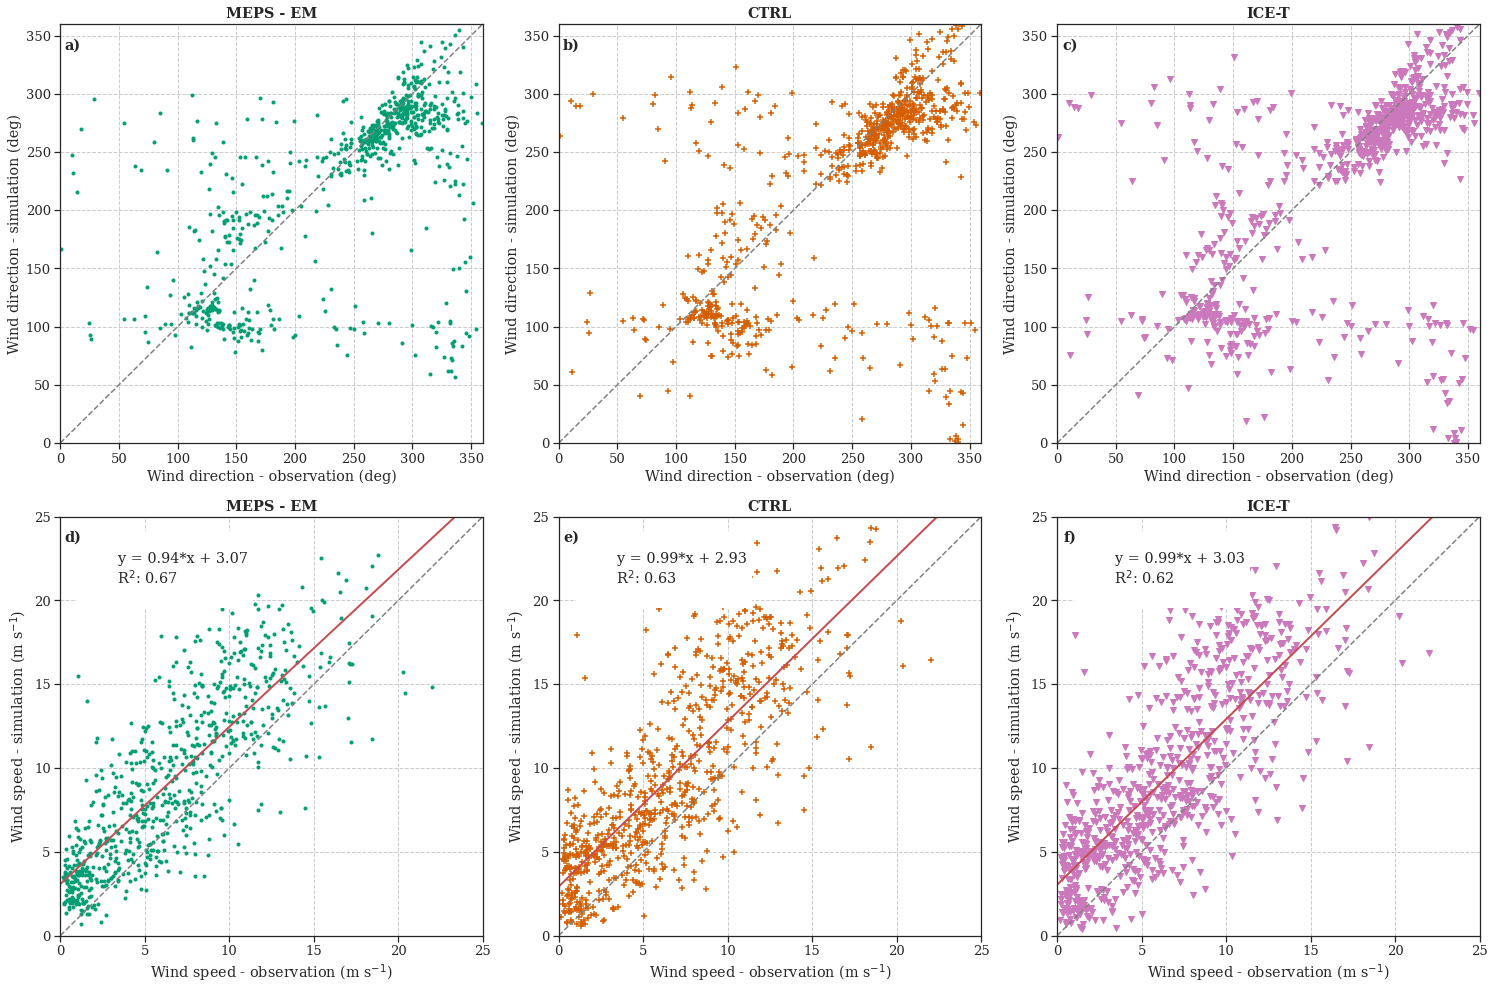

In [34]:
fig, axsm = plt.subplots(2, 3, #sharex = 'all', 
                             # sharey = 'all',
                             figsize = [21,14])

axs = axsm.flatten()

axs[0].scatter(obs_wd, meps_wd['MEPS'], color = sns.color_palette("colorblind",5)[2], marker='.', )
axs[1].scatter(obs_wd, meps_wd['CTRL'], color = sns.color_palette("colorblind",5)[3], marker='+', )
axs[2].scatter(obs_wd, meps_wd['ICE-T'], color = sns.color_palette("colorblind",5)[4], marker='v', )

#annoate_correlation(axs[0], obs_wd[1:,].flatten(), meps_wd['MEPS'][1:,].flatten(), 'wd')
#annoate_correlation(axs[1], obs_wd[1:,].flatten(), meps_wd['CTRL'][1:,].flatten(), 'wd')
#annoate_correlation(axs[2], obs_wd[1:,].flatten(), meps_wd['ICE-T'][1:,].flatten(), 'wd')



for i in range(3):
    axs[i].set_ylim([0,360])
    axs[i].set_xlim([0,360])
    axs[i].set_ylabel('Wind direction - simulation (deg)')
    axs[i].set_xlabel('Wind direction - observation (deg)')
#    axs[i].legend(loc = 'upper center',#bbox_to_anchor=(0,.92,1,0.2), loc='lower left', #mode='expand',
 #             fancybox=True, facecolor ='white', )
    



axs[3].scatter(obs_ws, meps_ws['MEPS'], color = sns.color_palette("colorblind",5)[2], marker='.', )
axs[4].scatter(obs_ws, meps_ws['CTRL'], color = sns.color_palette("colorblind",5)[3], marker='+', )
axs[5].scatter(obs_ws, meps_ws['ICE-T'], color = sns.color_palette("colorblind",5)[4], marker='v', )

annoate_correlation(axs[3], obs_ws[1:,].flatten(), meps_ws['MEPS'][1:,].flatten(), 'ws')
annoate_correlation(axs[4], obs_ws[1:,].flatten(), meps_ws['CTRL'][1:,].flatten(), 'ws')
annoate_correlation(axs[5], obs_ws[1:,].flatten(), meps_ws['ICE-T'][1:,].flatten(), 'ws')

for i in np.arange(3,6):
    axs[i].set_ylim([0,25])
    axs[i].set_xlim([0,25])
    axs[i].set_ylabel('Wind speed - simulation (m s$^{-1}$)')
    axs[i].set_xlabel('Wind speed - observation (m s$^{-1}$)')

_titel = ['MEPS - EM', 'CTRL', 'ICE-T', 'MEPS - EM', 'CTRL', 'ICE-T']
for i in range(len(axs)):
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, ls='--', color='grey')
    axs[i].text(0.03, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
    axs[i].set_title(_titel[i], fontweight='bold')

plt.tight_layout()
if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_wind_corr.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

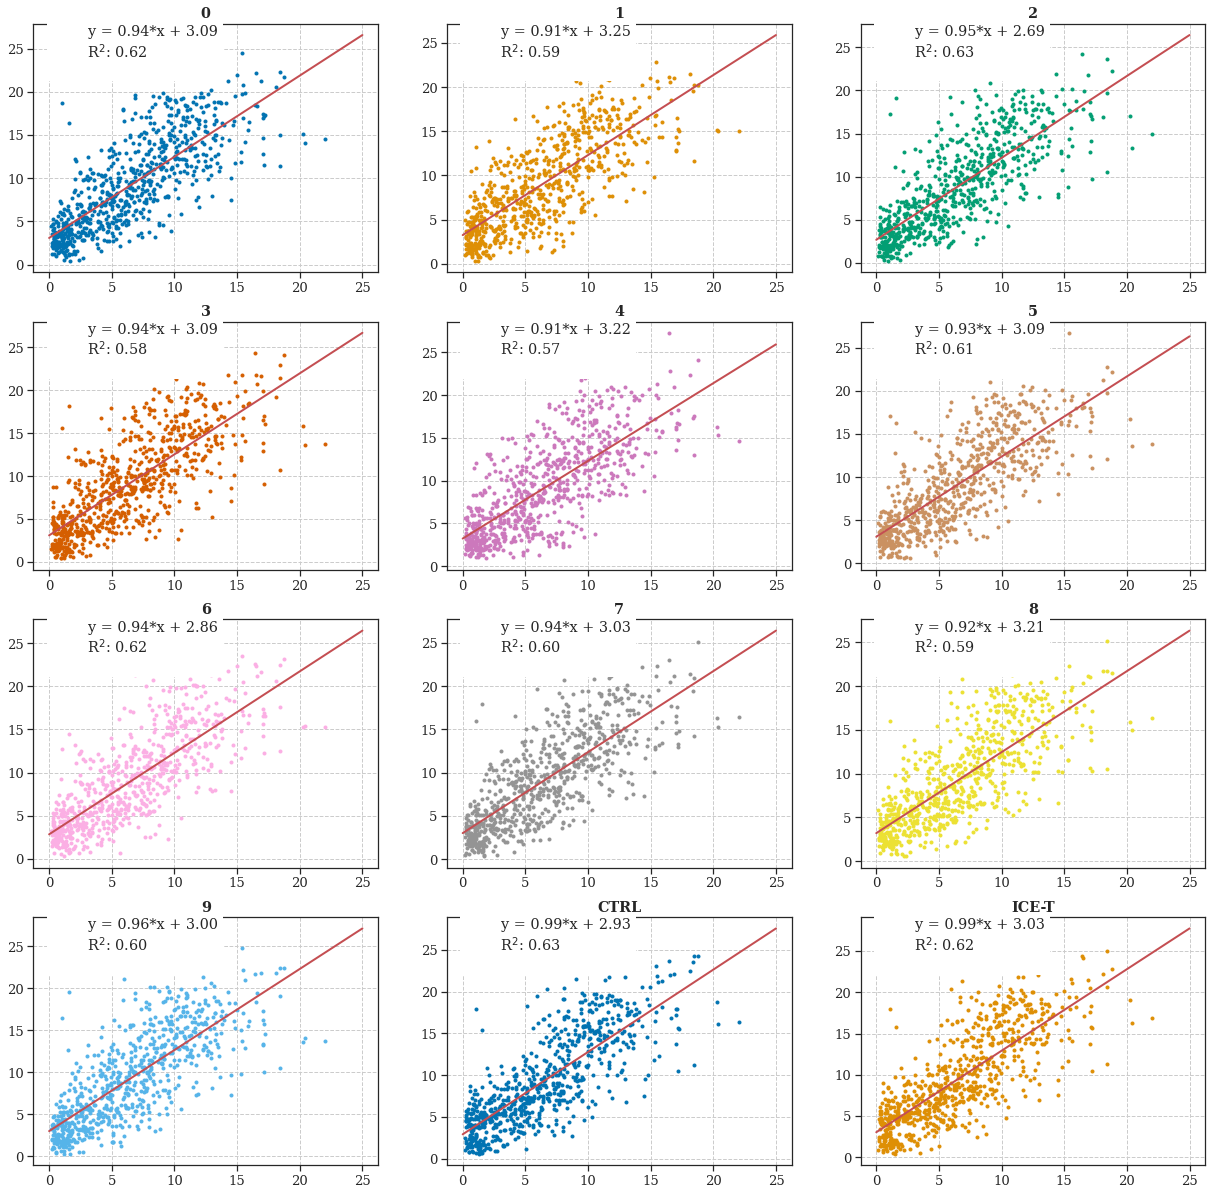

In [35]:
fig, axsm = plt.subplots(4, 3, #sharex = 'all', 
                             # sharey = 'all',
                             figsize = [21,21])

axs = axsm.flatten()

for i, meps in zip(range(len(axs)), meps_run):
        axs[i].scatter(obs_ws, meps_ws[meps], color = sns.color_palette("colorblind",len(meps_run))[i], marker='.', label=meps)
        annoate_correlation(axs[i], obs_ws[~np.isnan(meps_ws[meps][:,])], meps_ws[meps][~np.isnan(meps_ws[meps][:,])], 'ws')
        axs[i].set_title(meps, fontweight='bold')

In [36]:
# calculate wind speed ensemble mean for each date
meps_wind_speed['MEPS'] = dict()
for Date in date:
    meps_wind_speed['MEPS'][Date] = (np.nanmean(np.stack((meps_wind_speed['0'][Date], meps_wind_speed['1'][Date], 
                                      meps_wind_speed['2'][Date], meps_wind_speed['3'][Date],
                                      meps_wind_speed['4'][Date], meps_wind_speed['5'][Date],
                                      meps_wind_speed['6'][Date], meps_wind_speed['7'][Date],
                                      meps_wind_speed['8'][Date], meps_wind_speed['9'][Date]), ), axis =0))
    


In [37]:
### correct wind speed in model simulations according the regression line
# meps - em: y = 0.94 * x + 3.07  -> x = (y-3.07)/0.94
# meps 0:    y = 0.94 * x + 3.09
# meps 1:    y = 0.91 * x + 3.25
# meps 2:    y = 0.95 * x + 2.69
# meps 3:    y = 0.94 * x + 3.09
# meps 4:    y = 0.91 * x + 3.22
# meps 5:    y = 0.93 * x + 3.09
# meps 6:    y = 0.94 * x + 2.86
# meps 7:    y = 0.94 * x + 3.03
# meps 8:    y = 0.92 * x + 3.21
# meps 9:    y = 0.96 * x + 3.00


# ctrl:      y = 0.99 * x + 2.93  -> x = (y-2.93)/0.99
# ice-t:     y = 0.99 * x + 3.03  -> x = (y-3.03)/0.99



In [38]:
meps_wind_speed_corr = dict()
meps_ws_corr = dict()

meps_ws_corr['MEPS'] = np.empty(shape = (24,))
meps_ws_corr['MEPS'][:] = np.nan
meps_wind_speed_corr['MEPS'] = dict()

for meps in meps_run:
    meps_ws_corr[meps] = meps_ws_corr['MEPS']
    meps_wind_speed_corr[meps] = dict()

for Date in date:
    
    meps_wind_speed_corr['MEPS'][Date] = (meps_wind_speed['MEPS'][Date] - 3.07) / 0.94    # ensemble mean
    meps_wind_speed_corr['0'][Date]    = (meps_wind_speed['0'][Date] - 3.09) / 0.94
    meps_wind_speed_corr['1'][Date]    = (meps_wind_speed['1'][Date] - 3.25) / 0.91
    meps_wind_speed_corr['2'][Date]    = (meps_wind_speed['2'][Date] - 2.69) / 0.95
    meps_wind_speed_corr['3'][Date]    = (meps_wind_speed['3'][Date] - 3.09) / 0.94
    meps_wind_speed_corr['4'][Date]    = (meps_wind_speed['4'][Date] - 3.22) / 0.91
    meps_wind_speed_corr['5'][Date]    = (meps_wind_speed['5'][Date] - 3.09) / 0.93
    meps_wind_speed_corr['6'][Date]    = (meps_wind_speed['6'][Date] - 2.86) / 0.94
    meps_wind_speed_corr['7'][Date]    = (meps_wind_speed['7'][Date] - 3.03) / 0.94
    meps_wind_speed_corr['8'][Date]    = (meps_wind_speed['8'][Date] - 3.21) / 0.92
    meps_wind_speed_corr['9'][Date]    = (meps_wind_speed['9'][Date] - 3.00) / 0.96
    
    meps_wind_speed_corr['CTRL'][Date] = (meps_wind_speed['CTRL'][Date] - 2.93) / 0.99
    meps_wind_speed_corr['ICE-T'][Date] = (meps_wind_speed['ICE-T'][Date] - 3.03) / 0.99 
    
    meps_ws_corr['MEPS'] = np.vstack((meps_ws_corr['MEPS'], meps_wind_speed_corr['MEPS'][Date][1:,]))
    for meps in meps_run:
        meps_ws_corr[meps] = np.vstack((meps_ws_corr[meps], meps_wind_speed_corr[meps][Date][1:,]))


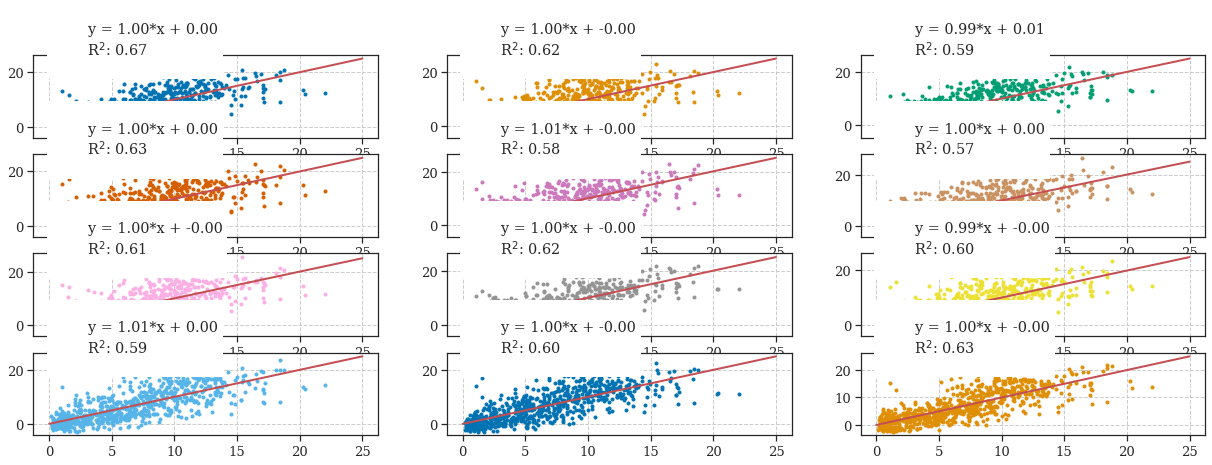

In [39]:
fig, axsm = plt.subplots(4, 3, #sharex = 'all', 
                             # sharey = 'all',
                             figsize = [21,7])

axs = axsm.flatten()
for i, meps in zip(range(len(axs)), meps_ws_corr.keys()):
    axs[i].scatter(obs_ws, meps_ws_corr[meps], color = sns.color_palette("colorblind",len(meps_ws_corr.keys()))[i], marker='.', label='MEPS-EM')
    annoate_correlation(axs[i], obs_ws[~np.isnan(meps_ws_corr[meps][:,])], meps_ws_corr[meps][~np.isnan(meps_ws_corr[meps][:,])], 'ws')


In [40]:
meps_precip_west_ws_corr = dict()
meps_precip_east_ws_corr = dict()

meps_west_count_corr = dict()
meps_east_count_corr = dict()

for meps in meps_run:
    ### meps forecast
    meps_precip_west_0_4_corr, meps_precip_east_0_4_corr, \
    meps_precip_west_4_8_corr, meps_precip_east_4_8_corr, \
    meps_precip_west_8_12_corr, meps_precip_east_8_12_corr, \
    meps_precip_west_12_16_corr,meps_precip_east_12_16_corr, \
    meps_precip_west_16_20_corr,meps_precip_east_16_20_corr, \
    meps_precip_west_20_corr,meps_precip_east_20_corr =  fct.get_precip_amount_for_wind_speed_MEPS(meps_precip_diff_2deg[meps], 
                                                                                               meps_wind_dir[meps], 
                                                                                               meps_west_idx[meps], 
                                                                                               meps_east_idx[meps], 
                                                                                               meps_wind_speed_corr[meps])

    meps_precip_west_ws_corr[meps] = [np.nansum(meps_precip_west_0_4_corr[:,:],axis= 0),
                          np.nansum(meps_precip_west_4_8_corr[:,:],axis= 0),
                          np.nansum(meps_precip_west_8_12_corr[:,:],axis= 0),
                          np.nansum(meps_precip_west_12_16_corr[:,:],axis= 0),
                          np.nansum(meps_precip_west_16_20_corr[:,:],axis= 0),
                          np.nansum(meps_precip_west_20_corr[:,:],axis= 0)]
    meps_precip_west_ws_corr[meps] = np.array(meps_precip_west_ws_corr[meps])
#    meps_precip_west_ws[meps][np.where(meps_precip_west_ws[meps][:,:] == 0.0)] = np.nan

    #meps_precip_west_ws_mean = np.nanmean(meps_precip_west_ws[:,1:], axis = 1)

    meps_precip_east_ws_corr[meps] = [np.nansum(meps_precip_east_0_4_corr[:,:],axis= 0),
                          np.nansum(meps_precip_east_4_8_corr[:,:],axis= 0),
                          np.nansum(meps_precip_east_8_12_corr[:,:],axis= 0),
                          np.nansum(meps_precip_east_12_16_corr[:,:],axis= 0),
                          np.nansum(meps_precip_east_16_20_corr[:,:],axis= 0),
                          np.nansum(meps_precip_east_20_corr[:,:],axis= 0)]
    meps_precip_east_ws_corr[meps] = np.array(meps_precip_east_ws_corr[meps])
    
    
        ### count the hours precipitation was observed
    meps_west_ones_0_4_corr = np.ones(shape = meps_precip_west_0_4_corr[:,1].shape[0])
    meps_west_count_0_4_corr = np.sum(meps_west_ones_0_4_corr[np.logical_and(meps_precip_west_0_4_corr[:,1] != 0,
                                                                 ~np.isnan(meps_precip_west_0_4_corr[:,1]))])
    meps_west_ones_4_8_corr = np.ones(shape = meps_precip_west_4_8_corr[:,1].shape[0])
    meps_west_count_4_8_corr = np.sum(meps_west_ones_4_8_corr[np.logical_and(meps_precip_west_4_8_corr[:,1] != 0,
                                                                 ~np.isnan(meps_precip_west_4_8_corr[:,1]))])
    meps_west_ones_8_12_corr = np.ones(shape = meps_precip_west_8_12_corr[:,1].shape[0])
    meps_west_count_8_12_corr = np.sum(meps_west_ones_8_12_corr[np.logical_and(meps_precip_west_8_12_corr[:,1] != 0,
                                                                   ~np.isnan(meps_precip_west_8_12_corr[:,1]))])
    meps_west_ones_12_16_corr = np.ones(shape = meps_precip_west_12_16_corr[:,1].shape[0])
    meps_west_count_12_16_corr = np.sum(meps_west_ones_12_16_corr[np.logical_and(meps_precip_west_12_16_corr[:,1] != 0,
                                                                     ~np.isnan(meps_precip_west_12_16_corr[:,1]))])
    meps_west_ones_16_20_corr = np.ones(shape = meps_precip_west_16_20_corr[:,1].shape[0])
    meps_west_count_16_20_corr = np.sum(meps_west_ones_16_20_corr[np.logical_and(meps_precip_west_16_20_corr[:,1] != 0,
                                                                     ~np.isnan(meps_precip_west_16_20_corr[:,1]))])
    meps_west_ones_20_corr = np.ones(shape = meps_precip_west_20_corr[:,1].shape[0])
    meps_west_count_20_corr = np.sum(meps_west_ones_20_corr[np.logical_and(meps_precip_west_20_corr[:,1] != 0,
                                                                     ~np.isnan(meps_precip_west_20_corr[:,1]))])
    
    meps_east_ones_0_4_corr = np.ones(shape = meps_precip_east_0_4_corr[:,1].shape[0])
    meps_east_count_0_4_corr = np.sum(meps_east_ones_0_4_corr[np.logical_and(meps_precip_east_0_4_corr[:,1] != 0,
                                                                 ~np.isnan(meps_precip_east_0_4_corr[:,1]))])
    meps_east_ones_4_8_corr = np.ones(shape = meps_precip_east_4_8_corr[:,1].shape[0])
    meps_east_count_4_8_corr = np.sum(meps_east_ones_4_8_corr[np.logical_and(meps_precip_east_4_8_corr[:,1] != 0,
                                                                 ~np.isnan(meps_precip_east_4_8_corr[:,1]))])
    meps_east_ones_8_12_corr = np.ones(shape = meps_precip_east_8_12_corr[:,1].shape[0])
    meps_east_count_8_12_corr = np.sum(meps_east_ones_8_12_corr[np.logical_and(meps_precip_east_8_12_corr[:,1] != 0,
                                                                   ~np.isnan(meps_precip_east_8_12_corr[:,1]))])
    meps_east_ones_12_16_corr = np.ones(shape = meps_precip_east_12_16_corr[:,1].shape[0])
    meps_east_count_12_16_corr = np.sum(meps_east_ones_12_16_corr[np.logical_and(meps_precip_east_12_16_corr[:,1] != 0,
                                                                     ~np.isnan(meps_precip_east_12_16_corr[:,1]))])
    meps_east_ones_16_20_corr = np.ones(shape = meps_precip_east_16_20_corr[:,1].shape[0])
    meps_east_count_16_20_corr = np.sum(meps_east_ones_16_20_corr[np.logical_and(meps_precip_east_16_20_corr[:,1] != 0,
                                                                     ~np.isnan(meps_precip_east_16_20_corr[:,1]))])
    meps_east_ones_20_corr = np.ones(shape = meps_precip_east_20_corr[:,1].shape[0])
    meps_east_count_20_corr = np.sum(meps_east_ones_20_corr[np.logical_and(meps_precip_east_20_corr[:,1] != 0,
                                                                     ~np.isnan(meps_precip_east_20_corr[:,1]))])
    
    meps_west_count_corr[meps] = [meps_west_count_0_4_corr,
                  meps_west_count_4_8_corr,
                  meps_west_count_8_12_corr,
                  meps_west_count_12_16_corr,
                  meps_west_count_16_20_corr,
                  meps_west_count_20_corr]
    meps_west_count_corr[meps] = np.array(meps_west_count_corr[meps])
    
    meps_east_count_corr[meps] = [meps_east_count_0_4_corr,
                  meps_east_count_4_8_corr,
                  meps_east_count_8_12_corr,
                  meps_east_count_12_16_corr,
                  meps_east_count_16_20_corr,
                  meps_east_count_20_corr]
    meps_east_count_corr[meps] = np.array(meps_east_count_corr[meps])

In [41]:
# calculate ensemble mean
meps_precip_west_ws_corr['MEPS'] = np.nanmean(np.stack((meps_precip_west_ws_corr[str(0)][:,1], meps_precip_west_ws_corr[str(1)][:,1],
                                              meps_precip_west_ws_corr[str(2)][:,1], meps_precip_west_ws_corr[str(3)][:,1],
                                              meps_precip_west_ws_corr[str(4)][:,1], meps_precip_west_ws_corr[str(5)][:,1],
                                              meps_precip_west_ws_corr[str(6)][:,1], meps_precip_west_ws_corr[str(7)][:,1],
                                              meps_precip_west_ws_corr[str(8)][:,1], meps_precip_west_ws_corr[str(9)][:,1],), axis = 0), axis = 0)

meps_precip_east_ws_corr['MEPS'] = np.nanmean(np.stack((meps_precip_east_ws_corr[str(0)][:,1], meps_precip_east_ws_corr[str(1)][:,1],
                                              meps_precip_east_ws_corr[str(2)][:,1], meps_precip_east_ws_corr[str(3)][:,1],
                                              meps_precip_east_ws_corr[str(4)][:,1], meps_precip_east_ws_corr[str(5)][:,1],
                                              meps_precip_east_ws_corr[str(6)][:,1], meps_precip_east_ws_corr[str(7)][:,1],
                                              meps_precip_east_ws_corr[str(8)][:,1], meps_precip_east_ws_corr[str(9)][:,1],), axis = 0), axis = 0)

meps_west_count_corr['MEPS'] = np.nanmean(np.stack((meps_west_count_corr[str(0)], meps_west_count_corr[str(1)],
                                              meps_west_count_corr[str(2)], meps_west_count_corr[str(3)],
                                              meps_west_count_corr[str(4)], meps_west_count_corr[str(5)],
                                              meps_west_count_corr[str(6)], meps_west_count_corr[str(7)],
                                              meps_west_count_corr[str(8)], meps_west_count_corr[str(9)],), axis = 0), axis = 0)

meps_east_count_corr['MEPS'] = np.nanmean(np.stack((meps_east_count_corr[str(0)], meps_east_count_corr[str(1)],
                                              meps_east_count_corr[str(2)], meps_east_count_corr[str(3)],
                                              meps_east_count_corr[str(4)], meps_east_count_corr[str(5)],
                                              meps_east_count_corr[str(6)], meps_east_count_corr[str(7)],
                                              meps_east_count_corr[str(8)], meps_east_count_corr[str(9)],), axis = 0), axis = 0)

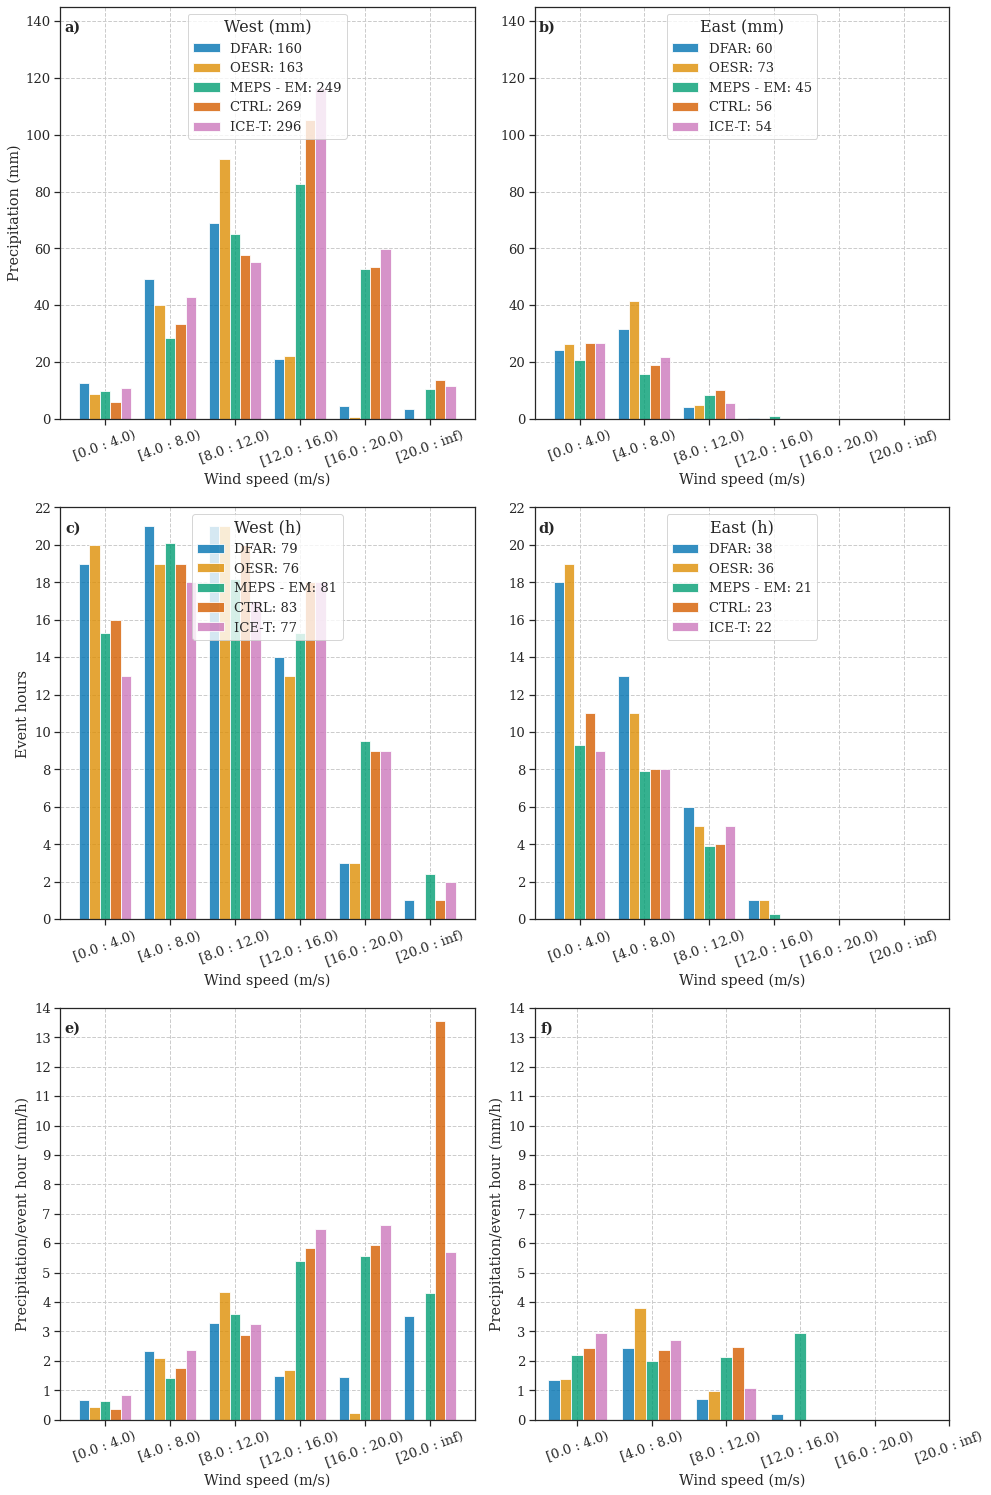

In [42]:
fig, axsm = plt.subplots(3, 2, #sharex = 'all', 
                             # sharey = 'all',
                             figsize = [14,21])

axs = axsm.flatten()

# westerlies
plt_bar_obs_ret_meps(axs[0], obs_precip_west_ws[:,1], -2, 'DFAR')
plt_bar_obs_ret_meps(axs[0], ret_precip_west_ws[:,1], -1, 'OESR')
plt_bar_obs_ret_meps(axs[0], meps_precip_west_ws_corr['MEPS'], 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[0], meps_precip_west_ws_corr['CTRL'][:,1], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[0], meps_precip_west_ws_corr['ICE-T'][:,1], +2, 'ICE-T')

axs[0].legend(loc = 'upper center', #bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', #mode='expand',
              fancybox=True, facecolor ='white', title = 'West (mm)', title_fontsize=16)
axs[0].set_ylabel('Precipitation (mm)')
axs[0].set_ylim([0, 145])

plt_bar_obs_ret_meps(axs[2], obs_west_count, -2, 'DFAR')
plt_bar_obs_ret_meps(axs[2], ret_west_count, -1, 'OESR')
plt_bar_obs_ret_meps(axs[2], meps_west_count_corr['MEPS'], 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[2], meps_west_count_corr['CTRL'], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[2], meps_west_count_corr['ICE-T'], +2, 'ICE-T')
axs[2].legend(loc = 'upper center',#bbox_to_anchor=(0,.92,1,0.2), loc='lower left', #mode='expand',
              fancybox=True, facecolor ='white', title = 'West (h)', title_fontsize=16)
axs[2].set_ylabel('Event hours')
axs[2].set_ylim([0, 22])
axs[2].set_yticks(np.arange(0,23,2))


plt_bar_obs_ret_meps(axs[4], obs_precip_west_ws[:,1]/obs_west_count, -2, 'DFAR')
plt_bar_obs_ret_meps(axs[4], ret_precip_west_ws[:,1]/ret_west_count, -1, 'OESR')
plt_bar_obs_ret_meps(axs[4], meps_precip_west_ws_corr['MEPS']/meps_west_count_corr['MEPS'], 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[4], meps_precip_west_ws_corr['CTRL'][:,1]/ meps_west_count_corr['CTRL'], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[4], meps_precip_west_ws_corr['ICE-T'][:,1]/ meps_west_count_corr['ICE-T'], +2, 'ICE-T')
axs[4].set_ylabel('Precipitation/event hour (mm/h)')
axs[4].set_ylim([0, 14])
axs[4].set_yticks(np.arange(0,15,1))



# easterlies
plt_bar_obs_ret_meps(axs[1], obs_precip_east_ws[:,1], -2, 'DFAR')
plt_bar_obs_ret_meps(axs[1], ret_precip_east_ws[:,1], -1, 'OESR')
plt_bar_obs_ret_meps(axs[1], meps_precip_east_ws_corr['MEPS'], 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[1], meps_precip_east_ws_corr['CTRL'][:,1], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[1], meps_precip_east_ws_corr['ICE-T'][:,1], +2, 'ICE-T')

axs[1].legend(loc = 'upper center',#bbox_to_anchor=(0,.92,1,0.2), loc='lower left', #mode='expand',
              fancybox=True, facecolor ='white', title = 'East (mm)', title_fontsize=16)
axs[1].set_ylim([0, 145])


plt_bar_obs_ret_meps(axs[3], obs_east_count, -2, 'DFAR')
plt_bar_obs_ret_meps(axs[3], ret_east_count, -1, 'OESR')
plt_bar_obs_ret_meps(axs[3], meps_east_count_corr['MEPS'], 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[3], meps_east_count_corr['CTRL'], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[3], meps_east_count_corr['ICE-T'], +2, 'ICE-T')
axs[3].legend(loc = 'upper center',#bbox_to_anchor=(0,.92,1,0.2), loc='lower left', #mode='expand',
              fancybox=True, facecolor ='white', title = 'East (h)', title_fontsize=16)
axs[3].set_ylim([0, 22])
axs[3].set_yticks(np.arange(0,23,2))

plt_bar_obs_ret_meps(axs[5], obs_precip_east_ws[:,1]/obs_east_count, -2, 'DFAR')
plt_bar_obs_ret_meps(axs[5], ret_precip_east_ws[:,1]/ret_east_count, -1, 'OESR')
plt_bar_obs_ret_meps(axs[5], meps_precip_east_ws_corr['MEPS']/meps_east_count_corr['MEPS'], 0, 'MEPS - EM')
plt_bar_obs_ret_meps(axs[5], meps_precip_east_ws_corr['CTRL'][:,1]/ meps_east_count_corr['CTRL'], +1, 'CTRL')
plt_bar_obs_ret_meps(axs[5], meps_precip_east_ws_corr['ICE-T'][:,1]/ meps_east_count_corr['ICE-T'], +2, 'ICE-T')
axs[5].set_ylabel('Precipitation/event hour (mm/h)')
axs[5].set_ylim([0, 14])
axs[5].set_yticks(np.arange(0,15,1))



for i in range(6):
    axs[i].text(0.03, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)

plt.tight_layout()
if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_sfc_precip_WS_WD_count_corr.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

In [ ]:
def get_hourly_acc_regime(obs_west_idx, obs_east_idx, 
                          obs_precip_diff_2deg, date):
    
    _west = np.empty(shape = (24, len(date)))
    _west[:] = np.nan

    _east = np.empty(shape = (24, len(date)))
    _east[:] = np.nan

    for Date, k in zip(date,range(len(date))):
        if len(obs_west_idx[Date]) + len(obs_east_idx[Date]) == 1440:  
            for i in range(int((len(obs_west_idx[Date])+ len(obs_east_idx[Date]))/60)):
                _res_w = (np.nansum(obs_precip_diff_2deg[Date][obs_west_idx[Date][np.where( (obs_west_idx[Date] >= i*60) & 
                                                                                           (obs_west_idx[Date] < (i+1)*60))]]))
                _res_e = (np.nansum(obs_precip_diff_2deg[Date][obs_east_idx[Date][np.where( (obs_east_idx[Date] >= i*60) & 
                                                                                           (obs_east_idx[Date] < (i+1)*60))]]))
                if _res_w == 0:
                    _west[i,k] = np.nan
                    _east[i,k] = _res_e
                if _res_e == 0:
                    _east[i,k] = np.nan
                    _west[i,k] = _res_w
                else:
                    _west[i,k] = _res_w
                    _east[i,k] = _res_e


        if len(obs_west_idx[Date]) + len(obs_east_idx[Date]) == 24:
            for i in range(int((len(obs_west_idx[Date])+ len(obs_east_idx[Date])))):
                _res_w = obs_precip_diff_2deg[Date][obs_west_idx[Date][np.where(obs_west_idx[Date] == i)]]
                _res_e = obs_precip_diff_2deg[Date][obs_east_idx[Date][np.where(obs_east_idx[Date] == i)]]

                if len(_res_e) == 0 and len(_res_w) != 0:
                    _east[i,k] = np.nan
                    if _res_w == 0:
                        _west[i,k] = np.nan
                    else:
                        _west[i,k] = _res_w
                if len(_res_w) == 0 and len(_res_e) != 0:
                    _west[i,k] = np.nan
                    if _res_e == 0:
                        _east[i,k] = np.nan
                    else:
                        _east[i,k] = _res_e
                        
    return(_west, _east)

In [ ]:
obs_west_hourly_acc, obs_east_hourly_acc = get_hourly_acc_regime(obs_west_idx, obs_east_idx, 
                          obs_precip_diff_2deg, date)

obs_west_hourly_acc[np.where(obs_west_hourly_acc <= 0)] = np.nan
obs_east_hourly_acc[np.where(obs_east_hourly_acc <= 0)] = np.nan

In [ ]:
ret_west_hourly_acc, ret_east_hourly_acc = get_hourly_acc_regime(obs_west_idx, obs_east_idx, 
                          ret_precip_diff, date)

ret_west_hourly_acc[np.where(ret_west_hourly_acc <= 0)] = np.nan
ret_east_hourly_acc[np.where(ret_east_hourly_acc <= 0)] = np.nan

In [ ]:
_obs_pp = []
for key, value in obs_precip_west_2deg.items():
    _obs_pp.append(value)

_ret_pp = []
for key, value in ret_precip_west.items():
    _ret_pp.append(value)
    
_obs_pp_e = []
for key, value in obs_precip_east_2deg.items():
    _obs_pp_e.append(value)

_ret_pp_e = []
for key, value in ret_precip_east.items():
    _ret_pp_e.append(value)

In [ ]:
obs_precip_west_0_20 = (np.stack( (obs_precip_west_0_4[:,1], 
                        obs_precip_west_4_8[:,1], 
                        obs_precip_west_8_12[:,1],
                        obs_precip_west_12_16[:,1],
                        obs_precip_west_16_20[:,1],
                        obs_precip_west_20[:,1])))

obs_precip_east_0_20 = (np.stack( (obs_precip_east_0_4[:,1], 
                        obs_precip_east_4_8[:,1], 
                        obs_precip_east_8_12[:,1],
                        obs_precip_east_12_16[:,1],
                        obs_precip_east_16_20[:,1],
                        obs_precip_east_20[:,1])))

In [ ]:
ret_precip_west_0_20 = (np.stack( (ret_precip_west_0_4[:,1], 
                        ret_precip_west_4_8[:,1], 
                        ret_precip_west_8_12[:,1],
                        ret_precip_west_12_16[:,1],
                        ret_precip_west_16_20[:,1],
                        ret_precip_west_20[:,1])))

ret_precip_east_0_20 = (np.stack( (ret_precip_east_0_4[:,1], 
                        ret_precip_east_4_8[:,1], 
                        ret_precip_east_8_12[:,1],
                        ret_precip_east_12_16[:,1],
                        ret_precip_east_16_20[:,1],
                        ret_precip_east_20[:,1])))

In [ ]:
pearsonr_w = pearsonr(obs_precip_west_0_20[~np.isnan(obs_precip_west_0_20[:])],
                      ret_precip_west_0_20[~np.isnan(obs_precip_west_0_20[:])])[0]

spearmanr_w = spearmanr(obs_precip_west_0_20[~np.isnan(obs_precip_west_0_20[:])],
         ret_precip_west_0_20[~np.isnan(obs_precip_west_0_20[:])])[0]

kendalltau_w = kendalltau(obs_precip_west_0_20[~np.isnan(obs_precip_west_0_20[:])],
         ret_precip_west_0_20[~np.isnan(obs_precip_west_0_20[:])])[0]

In [ ]:
pearsonr_e = pearsonr(obs_precip_east_0_20[~np.isnan(obs_precip_east_0_20[:])],
         ret_precip_east_0_20[~np.isnan(obs_precip_east_0_20[:])])[0]

spearmanr_e = spearmanr(obs_precip_east_0_20[~np.isnan(obs_precip_east_0_20[:])],
         ret_precip_east_0_20[~np.isnan(obs_precip_east_0_20[:])])[0]

kendalltau_e = kendalltau(obs_precip_east_0_20[~np.isnan(obs_precip_east_0_20[:])],
         ret_precip_east_0_20[~np.isnan(obs_precip_east_0_20[:])])[0]

In [ ]:
def plt_number_obs(axs, obs_west, ret_west,regime,vmax = None):
    
    axs.plot([0, 1], [0, 1], transform=axs.transAxes, color='grey', ls='--')
    
    mask = ~np.isnan(obs_west) & ~np.isnan(ret_west)
    x = obs_west[mask]#np.random.normal(size=500)
    y = ret_west[mask]#x * 3 + np.random.normal(size=500)

#    x = x[~np.isnan(y)]
 #   y = y[~np.isnan(y)]
    
    cmap = plt.get_cmap('Spectral_r', 26)
    counts, xedges, yedges, im = axs.hist2d(x,y, 
                                           bins = 20, 
                                           range = [[0,5],[0,5]], 
                                           cmap = cmap,
                                           cmin=0.00000000001,
                                           norm = mpl.colors.Normalize(vmax = vmax))
    _x = np.linspace(0,5,10)
    _y = _x*linregress(x, y).slope + linregress(x, y).intercept
    
    axs.plot(_x, _y, 'r', linewidth = '2')
    
    annotation_string_w = r"""    {:}
    y = {:.2f}*x + {:.2f}
    R$^2$: {:.2f}
    """.format(regime,linregress(x, y).slope, linregress(x, y).intercept, linregress(x, y).rvalue**2, linregress(x,y).pvalue)
    axs.annotate(annotation_string_w, xy=(0.05, 0.80), xycoords='axes fraction',
                                             backgroundcolor='w', )
    return(im)

In [ ]:
fig, axsm = plt.subplots(1, 3, #sharex = 'all', 
                              #sharey = 'all',
                             figsize = [15,5])

axs = axsm.flatten()
fig.subplots_adjust(#right=0.8, 
    bottom = .1)
### 2D density plot of DFAR vs OESR 


## east
im = plt_number_obs(axs[1], obs_east_hourly_acc, ret_east_hourly_acc, regime = 'East',vmax = 120)

## west
im = plt_number_obs(axs[0], obs_west_hourly_acc, ret_west_hourly_acc, regime = 'West',vmax = 120)


#cbar_ax = fig.add_axes ([0.6, 0.15, 0.05, 0.7])

for i in range(2):   
    axs[i].set_aspect('equal')
    axs[i].set_xlabel('DFAR (mm/h)')
    axs[i].set_ylabel('OESR (mm/h)')
    axs[i].set_xticks(np.arange(6))

#p0 = axs[0].get_position.get_points().flatten()
#p1 = axs[1].get_position.get_points().flatten()
#ax_bar = fig.add_axes([p0[0], 0, p1[2]-p0[0], 0.05])

cbar = plt.colorbar(im, ax=axsm[:2],  #ax = axsm.ravel().tolist(),# cax=cbar_ax, 
                    norm = mpl.colors.NoNorm, #location = 'bottom', 
                    orientation = 'horizontal')
#cbar = plt.colorbar(im, norm = mpl.colors.NoNorm,)
cbar.ax.set_xlabel('Number of observations');

### scatter of west/east in wind speed category
axs[2].plot([0, 1], [0, 1], transform=axs[2].transAxes, color='grey', ls='--')
axs[2].set_facecolor('silver')

#cmap = ListedColormap(sns.color_palette("colorblind"), len(obs_precip_west_0_20))
#cmap = plt.get_cmap('hot', len(obs_precip_west_0_20))
cmap = plt.get_cmap('Spectral_r', len(obs_precip_west_0_20))
label = ['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)']

for i, in zip(range(len(obs_precip_west_0_20)),):
    axs[2].plot(obs_precip_west_0_20[i,~np.isnan(obs_precip_west_0_20[i,:])],
                ret_precip_west_0_20[i,~np.isnan(obs_precip_west_0_20[i,:])],
                'o', color = cmap(i), label = label[i], #alpha = 0.8
                  )
    axs[2].plot(obs_precip_east_0_20[i,~np.isnan(obs_precip_east_0_20[i,:])],
                ret_precip_east_0_20[i,~np.isnan(obs_precip_east_0_20[i,:])],
                'X', color = cmap(i), #label = label[i], 
               # alpha = 0.8
                  )
    
axs[2].legend(loc = 'lower right',
              fancybox=True, facecolor ='white', )
#axs[2].set_xlim([0,15])
#axs[2].set_ylim([0,15])
axs[2].set_xticks(np.arange(0,21,2))
axs[2].set_yticks(np.arange(0,21,2))
for i in range(3):
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)

    
axs[2].set_xlabel('DFAR (mm/d)')
axs[2].set_ylabel('OESR (mm/d)')

mask_w = ~np.isnan(obs_precip_west_0_20) & ~np.isnan(ret_precip_west_0_20)
mask_e = ~np.isnan(obs_precip_east_0_20) & ~np.isnan(ret_precip_east_0_20)


annotation_string_w = r"""         West       East
R$^2$:     {:.2f}       {:.2f}""".format(linregress(obs_precip_west_0_20[mask_w], ret_precip_west_0_20[mask_w]).rvalue**2, 
                                         linregress(obs_precip_east_0_20[mask_e], ret_precip_east_0_20[mask_e]).rvalue**2,  )#spearmanr_w, spearmanr_e, kendalltau_w, kendalltau_e)
#Spearman's $\rho$: {:.2f}       {:.2f}
#Kendall's $\tau$:     {:.2f}       {:.2f}


axs[2].annotate(annotation_string_w, xy=(0.1, 0.90), xycoords='axes fraction',
                                             backgroundcolor='w', );#fontsize=14)
#plt.tight_layout()
if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_sfc_2dhist_corr.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

In [ ]:
def calc_hourly_precip(date, obs_precip_diff_2deg):
    _total = np.empty(shape = (24, len(date)))
    _total[:] = np.nan
    for Date, k in zip(date,range(len(date))):
            if len(obs_precip_diff_2deg[Date]) == 1440:
                for i in range(int(len(obs_precip_diff_2deg[Date])/60)):
                    _res = np.nansum(obs_precip_diff_2deg[Date][i*60:(i+1)*59])
                    _total[i,k] = _res
            if len(obs_precip_diff_2deg[Date]) == 24:
                for i in range(len(obs_precip_diff_2deg[Date])):
                    _total[i,k] = obs_precip_diff_2deg[Date][i]
            if len(obs_precip_diff_2deg[Date]) == 25:
                for i in range(len(obs_precip_diff_2deg[Date])-1):
                    _total[i,k] = obs_precip_diff_2deg[Date][i]
    return(_total)

In [ ]:
obs_total_hourly = calc_hourly_precip(date, obs_precip_diff_2deg)

In [ ]:
ret_total_hourly = calc_hourly_precip(date, ret_precip_diff)

In [ ]:
meps_total_hourly = dict()
for meps in meps_run:
    meps_total_hourly[meps] = calc_hourly_precip(date, meps_precip_diff[meps])


In [ ]:
meps_total_hourly['EM'] = np.nanmean(np.dstack([meps_total_hourly[str(0)][:,:], meps_total_hourly[str(1)][:,:],
           meps_total_hourly[str(2)][:,:], meps_total_hourly[str(3)][:,:],
           meps_total_hourly[str(4)][:,:], meps_total_hourly[str(5)][:,:],
           meps_total_hourly[str(6)][:,:], meps_total_hourly[str(7)][:,:],
           meps_total_hourly[str(8)][:,:], meps_total_hourly[str(9)][:,:]]),axis = 2)

In [ ]:
from datetime import datetime, timedelta

first_date = datetime(int(str(int(date[0]))[0:4]), int(str(int(date[0]))[4:6]), int(str(int(date[0]))[6:8]))
first_date

result = first_date + np.arange(12,24) * timedelta(hours=1)

for Date in date[1:]:
    next_date = datetime(int(str(int(Date))[0:4]), int(str(int(Date))[4:6]), int(str(int(Date))[6:8]))
    result = np.append(result, (next_date + np.arange(24) * timedelta(hours=1)), axis =0)
last_date = datetime(int(str(int(date[-1]+1))[0:4]), int(str(int(date[-1]+1))[4:6]), int(str(int(date[-1]+1))[6:8]))
result = np.append(result, (last_date + np.arange(12) * timedelta(hours=1)), axis = 0)


In [ ]:
fig, axsm = plt.subplots(1, 1, sharex = 'all', 
                              sharey = 'all',
                             figsize = [14,7])
bar_width = 0.05
#opacity = 0.8
    
bar = axsm.plot(np.arange(len(result)),
                obs_total_hourly.flatten('F'), color = sns.color_palette("colorblind",5)[0], label = 'DFAR'  )
#bar = axsm.plot(np.arange(len(result)),
 #               ret_total_hourly.flatten('F'), color = sns.color_palette("colorblind",5)[1], label = 'OESR', linestyle = '--'  )
axsm.plot(np.arange(len(result)),
          meps_total_hourly['EM'].flatten('F'), color = sns.color_palette("colorblind",5)[2], label = 'MEPS', linestyle = '-.')  
#axsm.plot(np.arange(len(result)),
 #         meps_total_hourly['CTRL'].flatten('F'), color = sns.color_palette("colorblind",5)[3], label = 'CTRL', linestyle = ':')
#axsm.plot(np.arange(len(result)),
 #         meps_total_hourly['ICE-T'].flatten('F'), color = sns.color_palette("colorblind",5)[4], label = 'ICE-T', linestyle = '--')

axsm.axvspan(8*24, 13*24+12, color='lightgrey', alpha=0.5, lw=0)

axsm.set_xticks(np.arange(0, len(result), 24)) 
axsm.set_xticklabels([int(date[0]), int(date[1]), int(date[2]), 
                      int(date[3]), int(date[4]), int(date[5]),
                      int(date[6]), int(date[7]), int(date[8]), 
                      int(date[9]), int(date[10]), int(date[11]),
                      int(date[12]), int(date[13]), int(date[14]), 
                      int(date[15]), int(date[16]), int(date[17]),
                      int(date[18]), int(date[19]), int(date[20]), 
                      int(date[21]), int(date[22]), int(date[23]),
                      int(date[24]), int(date[25]), int(date[26]),
                      int(date[27]), int(date[28]), int(date[29]),
                      int(date[30])], rotation = 90);

axsm.legend(loc = 'upper right',
              fancybox=True, facecolor ='white', )
axsm.set_xlim([0, len(result) ])
axsm.set_ylabel('Precipitation mm/h');

plt.tight_layout()
if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_sfc_precip_hourly_acc.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()